# Problem Definition

We are here building a minimal version of self driving car. Here, we have a front camera view. This will transfer input to the computer. Then Deep Learning algorithm in computer predicts the steering angle to avoid all sorts of collisions. Predicting steering angle can be thought of as a regression problem. We will feed images to Convolutional Neural Network and the label will be the steering angle in that image. Model will learn the steering angle from the as per the turns in the image and will finally predicts steering angle for unknown images.

There are total 45406 images in the dataset along with their steering angles. We will split the dataset into train and test in a ratio of 70:30 sequentially.

## Import library

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import pi
import cv2
import scipy.misc
import random
import tensorflow as tf

In [4]:
# Credits: https://github.com/SullyChen/Autopilot-TensorFlow
# Research paper: End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]

# NVidia dataset: 72 hrs of video => 72*60*60*30 = 7,776,000 images
# Nvidia blog: https://devblogs.nvidia.com/deep-learning-self-driving-cars/


# Our Dataset: https://github.com/SullyChen/Autopilot-TensorFlow [https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view]
# Size: 25 minutes = 25*60*30 = 45,000 images ~ 2.3 GB


# If you want to try on a slightly large dataset: 70 minutes of data ~ 223GB
# Refer: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5
# Format: Image, latitude, longitude, gear, brake, throttle, steering angles and speed



# Additional Installations:
# pip3 install h5py


# AWS: https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/

# Youtube:https://www.youtube.com/watch?v=qhUvQiKec2U
# Further reading and extensions: https://medium.com/udacity/teaching-a-machine-to-steer-a-car-d73217f2492c
# More data: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5

## Import data

In [5]:
xs = []
ys = []

#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

#read data.txt
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)
print(str(len(ys)))#print length of ys

45406


In [6]:
#split the dataset
train_xs = xs[:int(len(xs) * 0.7)]
train_ys = ys[:int(len(xs) * 0.7)]

val_xs = xs[-int(len(xs) * 0.3):]
val_ys = ys[-int(len(xs) * 0.3):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

len(train_xs), len(train_ys), len(val_xs), len(val_ys)

(31784, 31784, 13621, 13621)

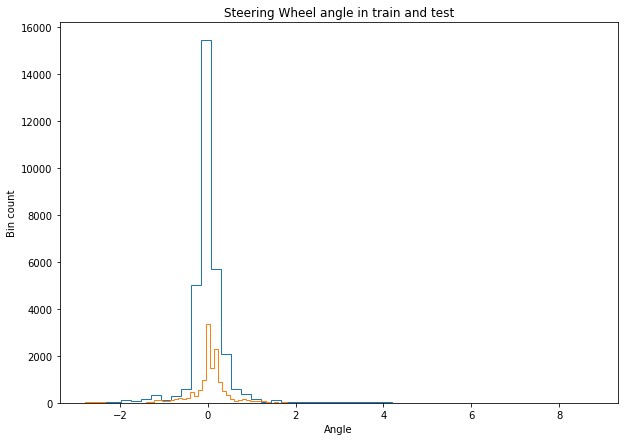

In [7]:
#ploting the angle dataset to check distribution
fig = plt.figure(figsize = (10, 7))
plt.hist(train_ys, bins = 50, histtype = "step")
plt.hist(val_ys, bins = 50, histtype = "step")
plt.title("Steering Wheel angle in train and test")
plt.xlabel("Angle")
plt.ylabel("Bin count")
plt.show()

1)Above histogram plot clearly shows that most of the values list on 0. This is obvious as well as most of the time car runs on straight road so therefore, steering wheel angle is 0 most of the time during driving.

2) both training and validation dataset have same distribution but validation data have less number of points

## Creating batch of images for training

In [8]:
def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

#here % len(test_x) is used to make sure that "test_batch_pointer + i" should not cross the number of test images. As soon as the value of "test_batch_pointer" is equal to number of test images then it will again start reading the test images from the beginning means from 0th index onwards.

#here, we are taking only the lower part of the images where there is a road in the image. As, we are concern only with the curves of the road to predict angles so therefore, we are discarding the upper part of the image. Hence, here -"150" is equivalent to the last 150 matrix pixels of the image.

#After, resizing, each image will be of size (66, 200, 3).now since we have kept only the last 150 matrices in the image so the size of our image is now (150, 455, 3). 

#Now 455/150 = 3.0303. Also 200/66 = 3.0303. Hence, here we are keeping the aspect ratio of images same.

#DIVIDE BY 255 MEANS here, we are normalizing the images

 #finally appending the image pixel matrix
 
 #appending corresponding labels

In [9]:
def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out

## Model Architecture

In [10]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

In [11]:
x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

In [12]:
#==================Convolutional layer
#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.multiply(tf.keras.activations.linear(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2)


so, here shape of Output_FC4_drop is 1*10 and shape of W_fc5 will be 10*1. Therefore, there will be a matrix multiplication of matrices: (1*10) * (10*1) = (1*1).

Since, this is a a regression problem so we have applied identity fuction in the end. We can also apply "atan" function here. If computational power is available then the model should be tested with both identity and atan functions. In the end, that function should be considered which gives better result.

## Training the model

In [14]:
import os
import tensorflow as tf
from tensorflow.core.protobuf import saver_pb2
import driving_data
import model

LOGDIR = './save1'

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(model.y_, model.y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(0.0001).minimize(loss)
sess.run(tf.global_variables_initializer())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver()

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

epochs = 30
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
  for i in range(int(driving_data.num_images/batch_size)):
    xs, ys = driving_data.LoadTrainBatch(batch_size)
    train_step.run(feed_dict={model.x: xs, model.y_: ys, model.keep_prob: 0.5})#keep prob 0.8 means dropout rate of (1-0.8)=0.2
    if i % 10 == 0:
      xs, ys = driving_data.LoadValBatch(batch_size)
      loss_value = loss.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={model.x:xs, model.y_: ys, model.keep_prob: 1.0})
    summary_writer.add_summary(summary, epoch * driving_data.num_images/batch_size + i)

    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")




Epoch: 0, Step: 0, Loss: 12.7209
Epoch: 0, Step: 10, Loss: 12.2536
Epoch: 0, Step: 20, Loss: 12.1024
Epoch: 0, Step: 30, Loss: 12.2089
Epoch: 0, Step: 40, Loss: 11.7453
Epoch: 0, Step: 50, Loss: 11.7285
Epoch: 0, Step: 60, Loss: 11.7688
Epoch: 0, Step: 70, Loss: 11.5046
Epoch: 0, Step: 80, Loss: 11.18
Epoch: 0, Step: 90, Loss: 11.028
Epoch: 0, Step: 100, Loss: 10.8634
Epoch: 0, Step: 110, Loss: 10.7526
Epoch: 0, Step: 120, Loss: 10.9106
Epoch: 0, Step: 130, Loss: 11.2509
Epoch: 0, Step: 140, Loss: 10.6495
Epoch: 0, Step: 150, Loss: 11.083
Epoch: 0, Step: 160, Loss: 10.3603
Epoch: 0, Step: 170, Loss: 10.5965
Epoch: 0, Step: 180, Loss: 10.2075
Epoch: 0, Step: 190, Loss: 9.76167
Epoch: 0, Step: 200, Loss: 9.63559
Epoch: 0, Step: 210, Loss: 9.56382
Epoch: 0, Step: 220, Loss: 9.53613
Epoch: 0, Step: 230, Loss: 10.3644
Epoch: 0, Step: 240, Loss: 9.38552
Epoch: 0, Step: 250, Loss: 11.0917
Epoch: 0, Step: 260, Loss: 9.53899
Epoch: 0, Step: 270, Loss: 10.0437
Epoch: 0, Step: 280, Loss: 8.87187


Epoch: 5, Step: 500, Loss: 2.52749
Epoch: 5, Step: 510, Loss: 2.5187
Epoch: 5, Step: 520, Loss: 2.51102
Epoch: 5, Step: 530, Loss: 2.50264
Epoch: 5, Step: 540, Loss: 2.49484
Epoch: 5, Step: 550, Loss: 2.48494
Epoch: 5, Step: 560, Loss: 2.47899
Epoch: 5, Step: 570, Loss: 2.48373
Epoch: 5, Step: 580, Loss: 2.51673
Epoch: 5, Step: 590, Loss: 5.30014
Epoch: 5, Step: 600, Loss: 5.29302
Epoch: 5, Step: 610, Loss: 2.44084
Epoch: 5, Step: 620, Loss: 2.42965
Epoch: 5, Step: 630, Loss: 2.45911
Epoch: 5, Step: 640, Loss: 2.45671
Epoch: 5, Step: 650, Loss: 2.43966
Epoch: 5, Step: 660, Loss: 2.46191
Epoch: 5, Step: 670, Loss: 2.52836
Epoch: 5, Step: 680, Loss: 2.38303
Epoch: 5, Step: 690, Loss: 2.40803
Epoch: 5, Step: 700, Loss: 2.39218
Epoch: 5, Step: 710, Loss: 2.37245
Epoch: 5, Step: 720, Loss: 2.36188
Epoch: 5, Step: 730, Loss: 2.42604
Epoch: 5, Step: 740, Loss: 2.40863
Epoch: 5, Step: 750, Loss: 2.43946
Epoch: 5, Step: 760, Loss: 2.46426
Epoch: 5, Step: 770, Loss: 2.3274
Epoch: 5, Step: 780, L

Epoch: 9, Step: 1340, Loss: 1.28344
Epoch: 9, Step: 1350, Loss: 1.38788
Model saved in file: ./save1\model.ckpt
Epoch: 10, Step: 1000, Loss: 2.11961
Epoch: 10, Step: 1010, Loss: 2.79964
Epoch: 10, Step: 1020, Loss: 1.49143
Epoch: 10, Step: 1030, Loss: 1.34963
Epoch: 10, Step: 1040, Loss: 1.24497
Epoch: 10, Step: 1050, Loss: 1.25113
Epoch: 10, Step: 1060, Loss: 1.24216
Epoch: 10, Step: 1070, Loss: 1.24623
Epoch: 10, Step: 1080, Loss: 1.2739
Epoch: 10, Step: 1090, Loss: 1.27524
Epoch: 10, Step: 1100, Loss: 1.22925
Epoch: 10, Step: 1110, Loss: 1.31499
Epoch: 10, Step: 1120, Loss: 1.58978
Epoch: 10, Step: 1130, Loss: 1.29053
Epoch: 10, Step: 1140, Loss: 1.36566
Epoch: 10, Step: 1150, Loss: 1.20505
Epoch: 10, Step: 1160, Loss: 1.20163
Epoch: 10, Step: 1170, Loss: 1.19984
Epoch: 10, Step: 1180, Loss: 1.19808
Epoch: 10, Step: 1190, Loss: 1.20521
Epoch: 10, Step: 1200, Loss: 5.71626
Epoch: 10, Step: 1210, Loss: 2.16245
Epoch: 10, Step: 1220, Loss: 1.17979
Epoch: 10, Step: 1230, Loss: 1.16935
E

Epoch: 14, Step: 1690, Loss: 0.592302
Epoch: 14, Step: 1700, Loss: 0.604462
Epoch: 14, Step: 1710, Loss: 0.591393
Epoch: 14, Step: 1720, Loss: 0.582778
Epoch: 14, Step: 1730, Loss: 0.601872
Epoch: 14, Step: 1740, Loss: 0.58468
Epoch: 14, Step: 1750, Loss: 0.588904
Epoch: 14, Step: 1760, Loss: 0.940428
Epoch: 14, Step: 1770, Loss: 0.582508
Epoch: 14, Step: 1780, Loss: 0.61154
Epoch: 14, Step: 1790, Loss: 0.625284
Epoch: 14, Step: 1800, Loss: 0.887453
Epoch: 14, Step: 1810, Loss: 0.593169
Epoch: 14, Step: 1820, Loss: 0.693192
Epoch: 14, Step: 1830, Loss: 0.836683
Epoch: 14, Step: 1840, Loss: 0.760239
Epoch: 14, Step: 1850, Loss: 0.581985
Model saved in file: ./save1\model.ckpt
Epoch: 15, Step: 1500, Loss: 0.580045
Epoch: 15, Step: 1510, Loss: 0.548672
Epoch: 15, Step: 1520, Loss: 0.575303
Epoch: 15, Step: 1530, Loss: 0.742183
Epoch: 15, Step: 1540, Loss: 1.26809
Epoch: 15, Step: 1550, Loss: 0.839631
Epoch: 15, Step: 1560, Loss: 1.4395
Epoch: 15, Step: 1570, Loss: 0.873995
Epoch: 15, Step

Epoch: 19, Step: 2010, Loss: 0.263101
Epoch: 19, Step: 2020, Loss: 0.265125
Epoch: 19, Step: 2030, Loss: 0.267337
Epoch: 19, Step: 2040, Loss: 0.516975
Epoch: 19, Step: 2050, Loss: 5.29772
Epoch: 19, Step: 2060, Loss: 0.309487
Epoch: 19, Step: 2070, Loss: 0.253783
Epoch: 19, Step: 2080, Loss: 0.248363
Epoch: 19, Step: 2090, Loss: 0.252395
Epoch: 19, Step: 2100, Loss: 0.253644
Epoch: 19, Step: 2110, Loss: 0.250558
Epoch: 19, Step: 2120, Loss: 0.265806
Epoch: 19, Step: 2130, Loss: 0.250362
Epoch: 19, Step: 2140, Loss: 0.258253
Epoch: 19, Step: 2150, Loss: 0.252792
Epoch: 19, Step: 2160, Loss: 0.25873
Epoch: 19, Step: 2170, Loss: 0.250279
Epoch: 19, Step: 2180, Loss: 0.2536
Epoch: 19, Step: 2190, Loss: 0.273841
Epoch: 19, Step: 2200, Loss: 0.27685
Epoch: 19, Step: 2210, Loss: 0.25072
Epoch: 19, Step: 2220, Loss: 0.248323
Epoch: 19, Step: 2230, Loss: 0.257504
Epoch: 19, Step: 2240, Loss: 0.244605
Epoch: 19, Step: 2250, Loss: 0.251187
Epoch: 19, Step: 2260, Loss: 0.246057
Epoch: 19, Step: 2

Epoch: 23, Step: 2700, Loss: 0.262557
Epoch: 23, Step: 2710, Loss: 0.15181
Epoch: 23, Step: 2720, Loss: 0.151505
Epoch: 23, Step: 2730, Loss: 0.155059
Epoch: 23, Step: 2740, Loss: 0.520766
Epoch: 23, Step: 2750, Loss: 0.433981
Model saved in file: ./save1\model.ckpt
Epoch: 24, Step: 2400, Loss: 0.840186
Epoch: 24, Step: 2410, Loss: 0.950805
Epoch: 24, Step: 2420, Loss: 0.267085
Epoch: 24, Step: 2430, Loss: 0.6974
Epoch: 24, Step: 2440, Loss: 0.26879
Epoch: 24, Step: 2450, Loss: 0.154001
Epoch: 24, Step: 2460, Loss: 0.167818
Epoch: 24, Step: 2470, Loss: 0.287374
Epoch: 24, Step: 2480, Loss: 0.245062
Epoch: 24, Step: 2490, Loss: 0.520234
Epoch: 24, Step: 2500, Loss: 0.854713
Epoch: 24, Step: 2510, Loss: 1.90295
Epoch: 24, Step: 2520, Loss: 0.69947
Epoch: 24, Step: 2530, Loss: 0.646455
Epoch: 24, Step: 2540, Loss: 0.142507
Epoch: 24, Step: 2550, Loss: 0.158338
Epoch: 24, Step: 2560, Loss: 0.860375
Epoch: 24, Step: 2570, Loss: 1.44691
Epoch: 24, Step: 2580, Loss: 0.291383
Epoch: 24, Step: 

Epoch: 28, Step: 3020, Loss: 0.14385
Epoch: 28, Step: 3030, Loss: 0.15654
Epoch: 28, Step: 3040, Loss: 0.136628
Epoch: 28, Step: 3050, Loss: 0.120999
Epoch: 28, Step: 3060, Loss: 0.124114
Epoch: 28, Step: 3070, Loss: 0.253218
Epoch: 28, Step: 3080, Loss: 0.152202
Epoch: 28, Step: 3090, Loss: 0.130296
Epoch: 28, Step: 3100, Loss: 0.195809
Epoch: 28, Step: 3110, Loss: 0.140299
Epoch: 28, Step: 3120, Loss: 0.150769
Epoch: 28, Step: 3130, Loss: 0.136285
Epoch: 28, Step: 3140, Loss: 0.154244
Epoch: 28, Step: 3150, Loss: 0.13534
Epoch: 28, Step: 3160, Loss: 0.152942
Epoch: 28, Step: 3170, Loss: 0.128382
Epoch: 28, Step: 3180, Loss: 0.114984
Epoch: 28, Step: 3190, Loss: 0.226234
Epoch: 28, Step: 3200, Loss: 0.139309
Epoch: 28, Step: 3210, Loss: 4.97825
Epoch: 28, Step: 3220, Loss: 0.884288
Epoch: 28, Step: 3230, Loss: 0.111958
Epoch: 28, Step: 3240, Loss: 0.127238
Epoch: 28, Step: 3250, Loss: 0.164202
Model saved in file: ./save1\model.ckpt
Epoch: 29, Step: 2900, Loss: 0.201151
Epoch: 29, Ste

## Making Predictions from the Model

In [15]:
#pip3 install opencv-python

import tensorflow as tf
import scipy.misc
import model
import cv2
from subprocess import call
import math

sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "save1/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0

#read data.txt
xs = []
ys = []
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)

i = math.ceil(num_images*0.7)
print("Starting frameofvideo:" +str(i))

while(cv2.waitKey(10) != ord('q')):
    full_image = scipy.misc.imread("driving_dataset/" + str(i) + ".jpg", mode="RGB")
    image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = model.y.eval(feed_dict={model.x: [image], model.keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.3 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2.imshow("steering wheel", dst)
    i += 1

cv2.destroyAllWindows()


INFO:tensorflow:Restoring parameters from save1/model.ckpt
Starting frameofvideo:31785


C:\Users\IDM LAB-01\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\IDM LAB-01\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Steering angle: -0.7382815506890251 (pred)	-28.34 (actual)
Steering angle: 0.462939122886063 (pred)	-28.840000000000003 (actual)
Steering angle: 0.44764462178711195 (pred)	-29.75 (actual)
Steering angle: 0.4549853675975831 (pred)	-31.06 (actual)
Steering angle: 0.1582217590101685 (pred)	-32.27 (actual)
Steering angle: -1.1767553628549257 (pred)	-33.48 (actual)
Steering angle: -1.35564356674626 (pred)	-34.39 (actual)
Steering angle: -1.0619138428108006 (pred)	-35.599999999999994 (actual)
Steering angle: -0.11051929095997633 (pred)	-36.5 (actual)
Steering angle: 0.5970631207307803 (pred)	-37.61 (actual)
Steering angle: 2.9526779715918186 (pred)	-38.62 (actual)
Steering angle: 6.601916137101285 (pred)	-39.63 (actual)
Steering angle: 8.90916044203394 (pred)	-39.93000000000001 (actual)
Steering angle: 9.821903380258485 (pred)	-40.03000000000001 (actual)
Steering angle: 9.880297228793863 (pred)	-40.03000000000001 (actual)
Steering angle: 10.114143269181236 (pred)	-40.03000000000001 (actual)


Steering angle: -0.12204523518437284 (pred)	-0.61 (actual)
Steering angle: -0.1749006540765165 (pred)	-0.61 (actual)
Steering angle: 0.3949637996056267 (pred)	-0.61 (actual)
Steering angle: 0.33533240617000726 (pred)	-0.61 (actual)
Steering angle: 0.29652924772151856 (pred)	-0.61 (actual)
Steering angle: 0.38401159127151124 (pred)	-0.61 (actual)
Steering angle: 0.4430709563641422 (pred)	-0.61 (actual)
Steering angle: 0.5504479334190895 (pred)	-0.5 (actual)
Steering angle: 0.5065584184730569 (pred)	-0.3 (actual)
Steering angle: 0.49269996464710103 (pred)	0.2 (actual)
Steering angle: 0.5793972633293654 (pred)	0.3 (actual)
Steering angle: 0.7001976965375034 (pred)	0.4 (actual)
Steering angle: 0.7217305082262033 (pred)	0.5 (actual)
Steering angle: 0.6685162909592224 (pred)	1.01 (actual)
Steering angle: 0.5400092699331944 (pred)	1.6100000000000003 (actual)
Steering angle: 0.5347794794630802 (pred)	2.12 (actual)
Steering angle: 0.4382531116783444 (pred)	2.52 (actual)
Steering angle: 0.515646

Steering angle: 15.197474846696437 (pred)	38.32 (actual)
Steering angle: 15.674631862113527 (pred)	38.72 (actual)
Steering angle: 15.401632616082702 (pred)	39.13 (actual)
Steering angle: 13.644929305896579 (pred)	39.43 (actual)
Steering angle: 11.865950187506106 (pred)	39.830000000000005 (actual)
Steering angle: 11.83547388342951 (pred)	39.93000000000001 (actual)
Steering angle: 9.699233182765056 (pred)	39.93000000000001 (actual)
Steering angle: 8.843420725046213 (pred)	40.13 (actual)
Steering angle: 8.864136688798862 (pred)	40.64000000000001 (actual)
Steering angle: 9.46194643458329 (pred)	41.24 (actual)
Steering angle: 12.657008183024997 (pred)	41.75 (actual)
Steering angle: 14.680996432227582 (pred)	42.959999999999994 (actual)
Steering angle: 16.784411243740955 (pred)	43.97 (actual)
Steering angle: 18.715602835332454 (pred)	44.57 (actual)
Steering angle: 22.152635987952912 (pred)	45.18 (actual)
Steering angle: 26.41941076623027 (pred)	45.88 (actual)
Steering angle: 29.24140587465859

Steering angle: -0.39882669846809204 (pred)	5.45 (actual)
Steering angle: -0.3088427981345822 (pred)	4.64 (actual)
Steering angle: -0.5147998954803236 (pred)	3.829999999999999 (actual)
Steering angle: -0.7132762281376085 (pred)	3.53 (actual)
Steering angle: -0.4841054522371094 (pred)	3.4300000000000006 (actual)
Steering angle: -0.22891037493839234 (pred)	3.4300000000000006 (actual)
Steering angle: -0.06650256374065228 (pred)	0.0 (actual)
Steering angle: 0.0866469260371355 (pred)	3.13 (actual)
Steering angle: 0.053738220842367825 (pred)	2.92 (actual)
Steering angle: 0.2718082317943037 (pred)	2.62 (actual)
Steering angle: 0.3516177115854333 (pred)	1.92 (actual)
Steering angle: 0.525579214651073 (pred)	1.21 (actual)
Steering angle: 0.8310547295248389 (pred)	1.01 (actual)
Steering angle: 0.9504622310291175 (pred)	1.01 (actual)
Steering angle: 1.2584772956136587 (pred)	1.01 (actual)
Steering angle: 1.9082193175352202 (pred)	1.01 (actual)
Steering angle: 2.2610613405293782 (pred)	1.21 (actua

Steering angle: -33.65752615423286 (pred)	-28.840000000000003 (actual)
Steering angle: -34.329640674224216 (pred)	-28.34 (actual)
Steering angle: -33.67226570246175 (pred)	-27.830000000000002 (actual)
Steering angle: -32.26697477129914 (pred)	-27.830000000000002 (actual)
Steering angle: -33.48991331200075 (pred)	-28.13 (actual)
Steering angle: -33.113351322679605 (pred)	-28.24 (actual)
Steering angle: -37.462303521955974 (pred)	-28.24 (actual)
Steering angle: -37.83341843541403 (pred)	-28.24 (actual)
Steering angle: -38.529411296743746 (pred)	-28.34 (actual)
Steering angle: -41.05042728920628 (pred)	-28.34 (actual)
Steering angle: -40.942619583346804 (pred)	-28.03 (actual)
Steering angle: -44.790174425841705 (pred)	-27.93 (actual)
Steering angle: -44.83155171183365 (pred)	-27.93 (actual)
Steering angle: -47.64822951799311 (pred)	-27.830000000000002 (actual)
Steering angle: -49.95081264570405 (pred)	-27.43 (actual)
Steering angle: -46.40700997597796 (pred)	-27.130000000000003 (actual)
S

Steering angle: 9.985369443890754 (pred)	-31.06 (actual)
Steering angle: 9.880292959925631 (pred)	-30.449999999999992 (actual)
Steering angle: 9.897514428144172 (pred)	-29.34 (actual)
Steering angle: 10.800970870418439 (pred)	-28.03 (actual)
Steering angle: 10.326355539146238 (pred)	-27.130000000000003 (actual)
Steering angle: 11.714294374722435 (pred)	-26.02 (actual)
Steering angle: 10.213769262188688 (pred)	-25.71 (actual)
Steering angle: 10.872363422717997 (pred)	-24.200000000000003 (actual)
Steering angle: 9.742330822654191 (pred)	-22.49 (actual)
Steering angle: 8.671888208004159 (pred)	-21.18 (actual)
Steering angle: 4.114859845192052 (pred)	-20.57 (actual)
Steering angle: 1.904674235912572 (pred)	-20.370000000000005 (actual)
Steering angle: 0.5779398717152139 (pred)	-20.07 (actual)
Steering angle: 0.27168230018148154 (pred)	-19.56 (actual)
Steering angle: -1.2836828280851214 (pred)	-18.35 (actual)
Steering angle: -2.2955890140008504 (pred)	-17.34 (actual)
Steering angle: -1.29344

Steering angle: 0.3807984141538434 (pred)	-3.3299999999999996 (actual)
Steering angle: 0.19201753502339158 (pred)	-4.03 (actual)
Steering angle: 0.08765565960018176 (pred)	-5.340000000000001 (actual)
Steering angle: -0.10797803370190845 (pred)	-6.76 (actual)
Steering angle: -0.028484450159891928 (pred)	-8.469999999999999 (actual)
Steering angle: 0.07889338066870166 (pred)	-9.380000000000003 (actual)
Steering angle: 0.4462538245173681 (pred)	-10.08 (actual)
Steering angle: 0.5084977653105174 (pred)	-11.5 (actual)
Steering angle: 0.6919207879239173 (pred)	-13.610000000000001 (actual)
Steering angle: 0.8697014339526521 (pred)	-14.82 (actual)
Steering angle: 0.9520003042528398 (pred)	-16.03 (actual)
Steering angle: 0.908461049945182 (pred)	-17.65 (actual)
Steering angle: 1.073724947433045 (pred)	-18.859999999999996 (actual)
Steering angle: 0.9819513240935803 (pred)	-19.36 (actual)
Steering angle: 1.1359240651097662 (pred)	-19.56 (actual)
Steering angle: 1.2041971419493327 (pred)	-19.76 (ac

Steering angle: 1.6968181325341556 (pred)	4.64 (actual)
Steering angle: 1.9705966604605962 (pred)	4.64 (actual)
Steering angle: 1.7801901963076814 (pred)	4.64 (actual)
Steering angle: 1.7450988187862717 (pred)	4.64 (actual)
Steering angle: 2.3000986464003517 (pred)	4.64 (actual)
Steering angle: 2.442705525750813 (pred)	4.64 (actual)
Steering angle: 2.3292816968462886 (pred)	4.54 (actual)
Steering angle: 2.350964345809906 (pred)	4.44 (actual)
Steering angle: 2.1367747360801834 (pred)	4.44 (actual)
Steering angle: 2.096167127030342 (pred)	4.44 (actual)
Steering angle: 2.399678108744083 (pred)	4.24 (actual)
Steering angle: 2.482546659509732 (pred)	4.13 (actual)
Steering angle: 2.7525145822095403 (pred)	4.13 (actual)
Steering angle: 2.7550703536195944 (pred)	4.13 (actual)
Steering angle: 2.2680377384363117 (pred)	4.03 (actual)
Steering angle: 2.3475515991024265 (pred)	4.13 (actual)
Steering angle: 2.3113148842345703 (pred)	4.24 (actual)
Steering angle: 2.4734834253679483 (pred)	4.24 (actua

Steering angle: 2.821255740450664 (pred)	11.899999999999999 (actual)
Steering angle: 3.9535405953932834 (pred)	11.899999999999999 (actual)
Steering angle: 5.039809185237057 (pred)	11.899999999999999 (actual)
Steering angle: 4.615324881151812 (pred)	11.899999999999999 (actual)
Steering angle: 4.025130369405126 (pred)	12.2 (actual)
Steering angle: 4.742479097835354 (pred)	12.61 (actual)
Steering angle: 3.1424564852279153 (pred)	12.709999999999999 (actual)
Steering angle: 3.1708852266573895 (pred)	12.81 (actual)
Steering angle: 3.340348409824341 (pred)	13.21 (actual)
Steering angle: 3.17064766414032 (pred)	13.82 (actual)
Steering angle: 2.7572359504733117 (pred)	14.52 (actual)
Steering angle: 2.989500161737592 (pred)	14.62 (actual)
Steering angle: 3.104632178264854 (pred)	14.62 (actual)
Steering angle: 2.3992535697984843 (pred)	14.62 (actual)
Steering angle: 2.5143211264154544 (pred)	14.62 (actual)
Steering angle: 2.6087638596165132 (pred)	14.62 (actual)
Steering angle: 2.4818329047414656

Steering angle: -50.56295810478269 (pred)	-67.97 (actual)
Steering angle: -52.55746896507479 (pred)	-69.07999999999998 (actual)
Steering angle: -57.106255423992806 (pred)	-69.58 (actual)
Steering angle: -59.27796871211172 (pred)	-69.58 (actual)
Steering angle: -57.56046300379866 (pred)	-69.88 (actual)
Steering angle: -55.73652245764928 (pred)	-69.98000000000002 (actual)
Steering angle: -51.379032521910396 (pred)	-69.98000000000002 (actual)
Steering angle: -50.518507233664245 (pred)	-69.98000000000002 (actual)
Steering angle: -48.35343630451317 (pred)	-69.98000000000002 (actual)
Steering angle: -46.527743814841685 (pred)	-69.98000000000002 (actual)
Steering angle: -44.393541925644485 (pred)	-69.98000000000002 (actual)
Steering angle: -35.64864582560205 (pred)	-69.68 (actual)
Steering angle: -33.49575995393028 (pred)	-69.38 (actual)
Steering angle: -33.407957872149765 (pred)	-68.87 (actual)
Steering angle: -31.286770908416024 (pred)	-67.45999999999998 (actual)
Steering angle: -29.0672497

Steering angle: 4.856873667375666 (pred)	21.98 (actual)
Steering angle: 3.965688940605797 (pred)	21.479999999999997 (actual)
Steering angle: 3.6024394168638323 (pred)	20.869999999999997 (actual)
Steering angle: 3.2989931085037947 (pred)	19.46 (actual)
Steering angle: 2.8454435747357953 (pred)	18.45 (actual)
Steering angle: 2.3165713551311296 (pred)	17.55 (actual)
Steering angle: 3.807377108475949 (pred)	17.34 (actual)
Steering angle: 4.726059323070643 (pred)	17.34 (actual)
Steering angle: 2.593091990565919 (pred)	17.34 (actual)
Steering angle: 3.0533387382585278 (pred)	17.34 (actual)
Steering angle: 3.022994128766865 (pred)	17.850000000000005 (actual)
Steering angle: 4.334467929367711 (pred)	18.66 (actual)
Steering angle: 5.489434561883472 (pred)	19.56 (actual)
Steering angle: 5.175324407238341 (pred)	20.469999999999995 (actual)
Steering angle: 4.059866150202872 (pred)	21.68 (actual)
Steering angle: 3.920633597745808 (pred)	22.59 (actual)
Steering angle: 3.6388635350470406 (pred)	23.5 

Steering angle: 14.578304538056441 (pred)	69.18 (actual)
Steering angle: 14.820226423363707 (pred)	69.07999999999998 (actual)
Steering angle: 13.640374423493828 (pred)	69.07999999999998 (actual)
Steering angle: 12.896627440808322 (pred)	0.0 (actual)
Steering angle: 12.35424638768584 (pred)	69.07999999999998 (actual)
Steering angle: 13.369980894631363 (pred)	68.97 (actual)
Steering angle: 12.984858116959254 (pred)	68.97 (actual)
Steering angle: 12.597463447614471 (pred)	68.97 (actual)
Steering angle: 13.493801125226293 (pred)	68.77 (actual)
Steering angle: 14.180740570811155 (pred)	68.07 (actual)
Steering angle: 15.601565913467315 (pred)	67.97 (actual)
Steering angle: 15.302827099549297 (pred)	68.07 (actual)
Steering angle: 13.668805939687651 (pred)	67.87 (actual)
Steering angle: 12.93338068873216 (pred)	67.06 (actual)
Steering angle: 13.765222597558845 (pred)	66.45 (actual)
Steering angle: 14.22377417767682 (pred)	0.0 (actual)
Steering angle: 14.69779699003852 (pred)	66.05 (actual)
Ste

Steering angle: -46.771134190820504 (pred)	-40.54 (actual)
Steering angle: -48.0809937188997 (pred)	-41.04 (actual)
Steering angle: -48.03690484780727 (pred)	-41.54999999999999 (actual)
Steering angle: -47.310087342753285 (pred)	-42.45 (actual)
Steering angle: -46.063950064535724 (pred)	-43.46 (actual)
Steering angle: -48.0396539989482 (pred)	-44.27 (actual)
Steering angle: -47.97515310752118 (pred)	-44.87 (actual)
Steering angle: -47.780987904890644 (pred)	-45.68 (actual)
Steering angle: -48.90693434428349 (pred)	-47.09 (actual)
Steering angle: -47.03946500255363 (pred)	-48.3 (actual)
Steering angle: -45.54006772500658 (pred)	-49.11 (actual)
Steering angle: -47.779973621798895 (pred)	-49.82 (actual)
Steering angle: -49.55996531573383 (pred)	-50.02 (actual)
Steering angle: -48.11947500468355 (pred)	-50.02 (actual)
Steering angle: -43.75861095549468 (pred)	-50.02 (actual)
Steering angle: -42.69264040720372 (pred)	-50.02 (actual)
Steering angle: -37.53894507463269 (pred)	-49.71 (actual)


Steering angle: -8.839384937020382 (pred)	-26.12 (actual)
Steering angle: -10.38775040204819 (pred)	-26.12 (actual)
Steering angle: -11.515305350990577 (pred)	-25.92 (actual)
Steering angle: -11.211495121613824 (pred)	-25.71 (actual)
Steering angle: -8.307245752558334 (pred)	-25.71 (actual)
Steering angle: -8.590842890860081 (pred)	0.0 (actual)
Steering angle: -8.301022596450807 (pred)	-25.210000000000004 (actual)
Steering angle: -7.303864496500427 (pred)	-23.799999999999997 (actual)
Steering angle: -6.116681996103831 (pred)	-22.59 (actual)
Steering angle: -4.865717481690363 (pred)	-21.78 (actual)
Steering angle: -5.6892905927531 (pred)	-21.28 (actual)
Steering angle: -4.804868180148366 (pred)	-20.77 (actual)
Steering angle: -4.507481743686011 (pred)	-20.07 (actual)
Steering angle: -4.831787663214679 (pred)	-19.26 (actual)
Steering angle: -4.510759380713971 (pred)	-18.25 (actual)
Steering angle: -4.49095268589458 (pred)	-16.54 (actual)
Steering angle: -4.59388875932855 (pred)	-14.32 (a

Steering angle: 0.5039407484736496 (pred)	9.78 (actual)
Steering angle: 0.17360505256832973 (pred)	9.78 (actual)
Steering angle: 0.24379549157396577 (pred)	9.88 (actual)
Steering angle: 0.15843733685584702 (pred)	9.48 (actual)
Steering angle: 0.0014620873692058544 (pred)	9.28 (actual)
Steering angle: 0.11799151791197027 (pred)	9.08 (actual)
Steering angle: -0.23713477647273395 (pred)	9.08 (actual)
Steering angle: 0.1604573653028783 (pred)	9.08 (actual)
Steering angle: 0.15053267355202665 (pred)	8.87 (actual)
Steering angle: 0.4200382778223898 (pred)	8.77 (actual)
Steering angle: 0.5160131078316471 (pred)	8.77 (actual)
Steering angle: 0.4628298398593428 (pred)	8.97 (actual)
Steering angle: 0.8443253601953506 (pred)	9.48 (actual)
Steering angle: 0.9220988032835817 (pred)	10.49 (actual)
Steering angle: 1.0255827859550333 (pred)	11.19 (actual)
Steering angle: 1.5133379070864568 (pred)	11.6 (actual)
Steering angle: 2.0815042049862056 (pred)	11.699999999999998 (actual)
Steering angle: 2.6387

Steering angle: 3.9606354543936337 (pred)	15.230000000000002 (actual)
Steering angle: 4.803789010259504 (pred)	15.43 (actual)
Steering angle: 4.5539496550437235 (pred)	15.53 (actual)
Steering angle: 3.06476030865467 (pred)	15.53 (actual)
Steering angle: 2.9820981576680023 (pred)	15.43 (actual)
Steering angle: 2.5205891056394107 (pred)	15.43 (actual)
Steering angle: 2.0970292249696447 (pred)	15.53 (actual)
Steering angle: 1.8187005103955058 (pred)	15.53 (actual)
Steering angle: 2.1267362789909687 (pred)	15.63 (actual)
Steering angle: 2.032352669614913 (pred)	15.63 (actual)
Steering angle: 2.608549348987893 (pred)	15.63 (actual)
Steering angle: 3.096262848654061 (pred)	15.63 (actual)
Steering angle: 2.703197414750875 (pred)	15.63 (actual)
Steering angle: 2.455742862772486 (pred)	15.63 (actual)
Steering angle: 2.4653025662895653 (pred)	15.53 (actual)
Steering angle: 2.4448841426526355 (pred)	15.53 (actual)
Steering angle: 2.6345789864713995 (pred)	15.43 (actual)
Steering angle: 2.99910404

Steering angle: -26.8026048692355 (pred)	-10.08 (actual)
Steering angle: -30.883929766263257 (pred)	-11.290000000000001 (actual)
Steering angle: -26.196282146424295 (pred)	-12.4 (actual)
Steering angle: -25.778219927706154 (pred)	-13.41 (actual)
Steering angle: -26.428771540487773 (pred)	-14.32 (actual)
Steering angle: -24.877536542234914 (pred)	-15.230000000000002 (actual)
Steering angle: -30.02099342124009 (pred)	-16.54 (actual)
Steering angle: -31.09536510221017 (pred)	-18.35 (actual)
Steering angle: -30.143305033802093 (pred)	-19.56 (actual)
Steering angle: -31.185178674701252 (pred)	-20.57 (actual)
Steering angle: -29.595322371786555 (pred)	-21.38 (actual)
Steering angle: -30.927004354263943 (pred)	-22.89 (actual)
Steering angle: -30.207713717675315 (pred)	-23.799999999999997 (actual)
Steering angle: -33.74130866968682 (pred)	-25.210000000000004 (actual)
Steering angle: -34.09900226142581 (pred)	-27.130000000000003 (actual)
Steering angle: -35.19306879286762 (pred)	-28.13 (actual)

Steering angle: -2.6972352999356883 (pred)	-17.75 (actual)
Steering angle: -2.4049851657291828 (pred)	-16.44 (actual)
Steering angle: -2.273508719961492 (pred)	-16.03 (actual)
Steering angle: -2.6072876849821442 (pred)	-16.03 (actual)
Steering angle: -2.363381202834166 (pred)	-16.03 (actual)
Steering angle: -1.964803379383956 (pred)	-15.83 (actual)
Steering angle: -1.6708589313764644 (pred)	-15.730000000000002 (actual)
Steering angle: -1.3340956005753393 (pred)	-15.730000000000002 (actual)
Steering angle: -1.1363116783451646 (pred)	-15.730000000000002 (actual)
Steering angle: -0.8804613297729493 (pred)	-15.730000000000002 (actual)
Steering angle: -0.18956635088500326 (pred)	-15.730000000000002 (actual)
Steering angle: 0.2304283844814277 (pred)	-15.730000000000002 (actual)
Steering angle: 0.43995852453673195 (pred)	-15.730000000000002 (actual)
Steering angle: 0.652076879400648 (pred)	-15.730000000000002 (actual)
Steering angle: 0.7032102368483022 (pred)	-15.730000000000002 (actual)
Stee

Steering angle: 16.165117991695897 (pred)	101.14 (actual)
Steering angle: 16.833158303847334 (pred)	99.83 (actual)
Steering angle: 16.545556113371024 (pred)	97.61 (actual)
Steering angle: 16.875006872892005 (pred)	95.9 (actual)
Steering angle: 17.111911984253897 (pred)	93.68 (actual)
Steering angle: 16.90057227095536 (pred)	92.06999999999998 (actual)
Steering angle: 17.227512935956362 (pred)	89.55 (actual)
Steering angle: 17.635784078499288 (pred)	87.73 (actual)
Steering angle: 17.436127403776062 (pred)	85.91999999999999 (actual)
Steering angle: 17.385083692561263 (pred)	83.8 (actual)
Steering angle: 17.222960614874548 (pred)	81.78000000000002 (actual)
Steering angle: 17.223148445076724 (pred)	80.47000000000001 (actual)
Steering angle: 16.983415635398444 (pred)	79.06 (actual)
Steering angle: 16.814248925130155 (pred)	77.85 (actual)
Steering angle: 16.905343158090616 (pred)	76.94 (actual)
Steering angle: 17.261353108199188 (pred)	75.33 (actual)
Steering angle: 17.274057260055415 (pred)	

Steering angle: -36.185857279296485 (pred)	-66.05 (actual)
Steering angle: -31.328592156704012 (pred)	-66.45 (actual)
Steering angle: -25.334162009006945 (pred)	-66.96 (actual)
Steering angle: -26.73481524172312 (pred)	-67.65999999999998 (actual)
Steering angle: -19.533220875212585 (pred)	-68.07 (actual)
Steering angle: -17.69845447922874 (pred)	-68.07 (actual)
Steering angle: -17.23528910632642 (pred)	0.0 (actual)
Steering angle: -16.8249210957083 (pred)	-68.37 (actual)
Steering angle: -15.524876549466413 (pred)	-68.77 (actual)
Steering angle: -15.121482161990874 (pred)	-68.77 (actual)
Steering angle: -16.206720673930445 (pred)	-68.87 (actual)
Steering angle: -17.27949067554016 (pred)	-68.87 (actual)
Steering angle: -19.89745095798727 (pred)	-68.87 (actual)
Steering angle: -19.84281627481634 (pred)	-68.87 (actual)
Steering angle: -22.401166081282163 (pred)	-68.87 (actual)
Steering angle: -23.6932500420464 (pred)	-68.57 (actual)
Steering angle: -26.983447787889926 (pred)	-67.56 (actual

Steering angle: 4.680945069829063 (pred)	-2.42 (actual)
Steering angle: 3.3721820005550662 (pred)	-2.22 (actual)
Steering angle: 1.241983882871959 (pred)	-1.71 (actual)
Steering angle: 1.1642529150226288 (pred)	-1.01 (actual)
Steering angle: 1.631853428573814 (pred)	-0.5 (actual)
Steering angle: 3.311247748535267 (pred)	-0.4 (actual)
Steering angle: 2.9411306830262656 (pred)	-0.4 (actual)
Steering angle: 2.7284070026471574 (pred)	-0.4 (actual)
Steering angle: 3.343094572757509 (pred)	0.0 (actual)
Steering angle: 3.0929397481794383 (pred)	0.3 (actual)
Steering angle: 2.016655614241754 (pred)	0.91 (actual)
Steering angle: 4.669162139737145 (pred)	1.51 (actual)
Steering angle: 5.977399924775285 (pred)	2.42 (actual)
Steering angle: 0.790058653465953 (pred)	2.82 (actual)
Steering angle: -0.18299528201662787 (pred)	2.92 (actual)
Steering angle: -2.6711200716441446 (pred)	2.92 (actual)
Steering angle: -3.825712751302848 (pred)	3.03 (actual)
Steering angle: -4.561742473999885 (pred)	0.0 (actua

Steering angle: -0.609058213573792 (pred)	4.74 (actual)
Steering angle: -0.8182933748343164 (pred)	4.94 (actual)
Steering angle: -1.119006967196114 (pred)	4.94 (actual)
Steering angle: -1.32446759516656 (pred)	5.139999999999999 (actual)
Steering angle: -2.2534791902204296 (pred)	5.45 (actual)
Steering angle: -1.8025671766891127 (pred)	6.25 (actual)
Steering angle: -1.304506367317198 (pred)	7.06 (actual)
Steering angle: -0.38861770009303864 (pred)	8.27 (actual)
Steering angle: -0.11692771594874078 (pred)	9.08 (actual)
Steering angle: -0.04025115855253139 (pred)	9.58 (actual)
Steering angle: -0.08585590475388341 (pred)	0.0 (actual)
Steering angle: 0.392653915005693 (pred)	9.78 (actual)
Steering angle: 0.5460194095159825 (pred)	0.0 (actual)
Steering angle: 0.5065024962992274 (pred)	9.88 (actual)
Steering angle: 0.5544824407844514 (pred)	10.18 (actual)
Steering angle: 0.3830459732776007 (pred)	10.389999999999999 (actual)
Steering angle: 0.19003208440903352 (pred)	10.389999999999999 (actual

Steering angle: 12.603633669755931 (pred)	67.36 (actual)
Steering angle: 11.597856724846643 (pred)	67.36 (actual)
Steering angle: 11.037034160965128 (pred)	67.36 (actual)
Steering angle: 9.703362885891975 (pred)	67.36 (actual)
Steering angle: 10.207370228710031 (pred)	67.36 (actual)
Steering angle: 10.66064634146782 (pred)	67.36 (actual)
Steering angle: 10.365373848553583 (pred)	0.0 (actual)
Steering angle: 10.840335811926161 (pred)	67.45999999999998 (actual)
Steering angle: 9.826089432446057 (pred)	0.0 (actual)
Steering angle: 10.674431370760198 (pred)	67.56 (actual)
Steering angle: 10.83262367457957 (pred)	67.75999999999999 (actual)
Steering angle: 13.542331326826526 (pred)	68.26999999999998 (actual)
Steering angle: 15.390502822830166 (pred)	69.18 (actual)
Steering angle: 16.03638600131408 (pred)	69.88 (actual)
Steering angle: 16.11351591251645 (pred)	70.69 (actual)
Steering angle: 16.0447871339932 (pred)	71.39 (actual)
Steering angle: 16.09746496796692 (pred)	72.0 (actual)
Steering 

Steering angle: -0.27926252949972635 (pred)	4.74 (actual)
Steering angle: -0.6976555855057893 (pred)	3.7300000000000004 (actual)
Steering angle: 0.4082830953739747 (pred)	2.92 (actual)
Steering angle: -0.5758844116618632 (pred)	1.51 (actual)
Steering angle: 0.035548573308977614 (pred)	0.81 (actual)
Steering angle: 0.11316513548971001 (pred)	0.61 (actual)
Steering angle: 0.35455981557041627 (pred)	0.61 (actual)
Steering angle: 0.26455457089575013 (pred)	0.61 (actual)
Steering angle: 0.41539716428136614 (pred)	0.61 (actual)
Steering angle: 0.3815697986432317 (pred)	0.4 (actual)
Steering angle: 0.4514191550771902 (pred)	0.1 (actual)
Steering angle: 0.3798712159740142 (pred)	-0.4 (actual)
Steering angle: 0.24241878156938507 (pred)	-1.01 (actual)
Steering angle: 0.33605213735379735 (pred)	-1.41 (actual)
Steering angle: 0.2511648388015864 (pred)	-1.51 (actual)
Steering angle: 0.6967388460531266 (pred)	-1.6100000000000003 (actual)
Steering angle: 0.7612948058803253 (pred)	-2.22 (actual)
Steer

Steering angle: 1.0821561756331912 (pred)	-7.969999999999999 (actual)
Steering angle: 0.7505620173732965 (pred)	-7.969999999999999 (actual)
Steering angle: 0.7337450244196673 (pred)	-7.969999999999999 (actual)
Steering angle: 0.6187096977578431 (pred)	-7.36 (actual)
Steering angle: 0.5035445975017888 (pred)	-7.36 (actual)
Steering angle: 0.17668333344988985 (pred)	-7.36 (actual)
Steering angle: -0.9954326234113046 (pred)	-7.36 (actual)
Steering angle: -1.9291672942762377 (pred)	-7.36 (actual)
Steering angle: -2.2177427867092763 (pred)	-7.26 (actual)
Steering angle: -2.0776214558864647 (pred)	-6.860000000000001 (actual)
Steering angle: -2.224145235282517 (pred)	-6.55 (actual)
Steering angle: -1.5674012022446349 (pred)	-6.150000000000001 (actual)
Steering angle: -2.192069386279668 (pred)	-5.949999999999999 (actual)
Steering angle: -2.152484598058036 (pred)	-5.949999999999999 (actual)
Steering angle: -2.3102602603380378 (pred)	-5.849999999999999 (actual)
Steering angle: -1.782267000702188

Steering angle: 10.286979498581115 (pred)	18.45 (actual)
Steering angle: 10.089974644803146 (pred)	19.66 (actual)
Steering angle: 9.831509187552461 (pred)	21.479999999999997 (actual)
Steering angle: 10.405911021277609 (pred)	22.789999999999996 (actual)
Steering angle: 10.277303681848146 (pred)	24.200000000000003 (actual)
Steering angle: 10.530814690629631 (pred)	26.22 (actual)
Steering angle: 10.654669072170412 (pred)	27.33 (actual)
Steering angle: 10.056277906532888 (pred)	27.73 (actual)
Steering angle: 10.310036509671786 (pred)	27.73 (actual)
Steering angle: 11.438618548310611 (pred)	27.73 (actual)
Steering angle: 11.533355833419627 (pred)	27.73 (actual)
Steering angle: 9.733992869224897 (pred)	27.73 (actual)
Steering angle: 9.939166629250202 (pred)	28.03 (actual)
Steering angle: 9.17502470170304 (pred)	28.44 (actual)
Steering angle: 9.119400494876102 (pred)	0.0 (actual)
Steering angle: 10.161384272575628 (pred)	29.849999999999998 (actual)
Steering angle: 10.63358513197623 (pred)	30.

Steering angle: 0.5072107015387931 (pred)	7.06 (actual)
Steering angle: 0.9964400763138814 (pred)	5.65 (actual)
Steering angle: 0.8055766298168104 (pred)	4.64 (actual)
Steering angle: 0.49547814409200375 (pred)	4.13 (actual)
Steering angle: 1.4247665752506702 (pred)	3.3299999999999996 (actual)
Steering angle: 0.5466430911645692 (pred)	2.82 (actual)
Steering angle: 1.070102172408588 (pred)	2.22 (actual)
Steering angle: 0.8290517765507327 (pred)	1.71 (actual)
Steering angle: 1.134739027288769 (pred)	0.0 (actual)
Steering angle: 1.5323832492568026 (pred)	0.71 (actual)
Steering angle: 3.0864788161114296 (pred)	0.3 (actual)
Steering angle: 1.2510131795113042 (pred)	0.0 (actual)
Steering angle: 1.7151074581407457 (pred)	-0.1 (actual)
Steering angle: 1.9756766136557933 (pred)	-0.4 (actual)
Steering angle: 1.9480055963373677 (pred)	-0.81 (actual)
Steering angle: 2.5334832221319252 (pred)	-1.21 (actual)
Steering angle: 2.0624834088081894 (pred)	-1.6100000000000003 (actual)
Steering angle: 3.673

Steering angle: -36.475785149185185 (pred)	-59.38999999999999 (actual)
Steering angle: -35.90697041020111 (pred)	-60.71 (actual)
Steering angle: -32.795166960194564 (pred)	-61.82 (actual)
Steering angle: -30.604281331075423 (pred)	-63.13 (actual)
Steering angle: -28.153244041754252 (pred)	-64.33999999999999 (actual)
Steering angle: -24.84917759680102 (pred)	-65.14 (actual)
Steering angle: -20.605256631486522 (pred)	-66.15 (actual)
Steering angle: -23.66423539845219 (pred)	-66.96 (actual)
Steering angle: -18.61491560168271 (pred)	-67.36 (actual)
Steering angle: -12.80887487789929 (pred)	-67.75999999999999 (actual)
Steering angle: -9.587335047366382 (pred)	-68.37 (actual)
Steering angle: -16.762161902519637 (pred)	-68.67 (actual)
Steering angle: -15.191880921766197 (pred)	-69.07999999999998 (actual)
Steering angle: -11.290295014068262 (pred)	-69.78000000000002 (actual)
Steering angle: -13.393163410448032 (pred)	-70.29 (actual)
Steering angle: -10.751085730041604 (pred)	-70.99 (actual)
St

Steering angle: -31.019830040179 (pred)	-41.95 (actual)
Steering angle: -28.279418126291898 (pred)	-42.349999999999994 (actual)
Steering angle: -19.684810093651848 (pred)	-42.76 (actual)
Steering angle: -15.917561200323371 (pred)	0.0 (actual)
Steering angle: -9.389856349214742 (pred)	-43.86999999999999 (actual)
Steering angle: -6.682773197156366 (pred)	-44.17 (actual)
Steering angle: -4.604423472349648 (pred)	-44.27 (actual)
Steering angle: -1.2390509569536732 (pred)	-44.27 (actual)
Steering angle: 0.08685481991999777 (pred)	-44.27 (actual)
Steering angle: 3.992961459074835 (pred)	-44.27 (actual)
Steering angle: 4.368202233678404 (pred)	-44.37 (actual)
Steering angle: 4.828064783230199 (pred)	-44.37 (actual)
Steering angle: -7.490056307048621 (pred)	-44.47 (actual)
Steering angle: -11.847708459780295 (pred)	-44.57 (actual)
Steering angle: -14.57558953786136 (pred)	-44.57 (actual)
Steering angle: -14.56510519748539 (pred)	-44.57 (actual)
Steering angle: -9.347335860310475 (pred)	-44.57 

Steering angle: -0.023159463928220735 (pred)	5.849999999999999 (actual)
Steering angle: -0.12814374033954798 (pred)	6.25 (actual)
Steering angle: -0.2855650865563556 (pred)	6.35 (actual)
Steering angle: -0.14498485239868378 (pred)	6.25 (actual)
Steering angle: -0.1382583967266906 (pred)	5.75 (actual)
Steering angle: -0.4312265545696938 (pred)	5.24 (actual)
Steering angle: -1.3317464423876781 (pred)	4.74 (actual)
Steering angle: -1.4663203789439698 (pred)	3.7300000000000004 (actual)
Steering angle: -1.4386350609169696 (pred)	2.92 (actual)
Steering angle: -0.9951346564087628 (pred)	2.42 (actual)
Steering angle: -1.0903325523999312 (pred)	2.42 (actual)
Steering angle: -1.152636257348318 (pred)	2.32 (actual)
Steering angle: -1.3123414480688487 (pred)	1.41 (actual)
Steering angle: -1.521762731984256 (pred)	0.81 (actual)
Steering angle: -1.7396000896175883 (pred)	0.3 (actual)
Steering angle: -1.6107024671484 (pred)	-0.4 (actual)
Steering angle: -1.95851490959249 (pred)	-0.81 (actual)
Steerin

Steering angle: -32.236758014411 (pred)	-6.860000000000001 (actual)
Steering angle: -33.95083155266614 (pred)	-7.06 (actual)
Steering angle: -34.56537440814345 (pred)	0.0 (actual)
Steering angle: -34.184062022254565 (pred)	-7.760000000000002 (actual)
Steering angle: -34.508677007843175 (pred)	-7.87 (actual)
Steering angle: -34.16125943571048 (pred)	-7.87 (actual)
Steering angle: -33.93696626865101 (pred)	-7.87 (actual)
Steering angle: -30.82547017715712 (pred)	-7.87 (actual)
Steering angle: -32.23364686324406 (pred)	-7.87 (actual)
Steering angle: -30.095148785058917 (pred)	-7.87 (actual)
Steering angle: -30.441818451477502 (pred)	-7.87 (actual)
Steering angle: -31.13177001048634 (pred)	-7.87 (actual)
Steering angle: -29.082965976481805 (pred)	-7.87 (actual)
Steering angle: -28.870943244266268 (pred)	-7.87 (actual)
Steering angle: -28.320754431148817 (pred)	-7.87 (actual)
Steering angle: -31.659449935194015 (pred)	-7.87 (actual)
Steering angle: -31.65298857623918 (pred)	-7.87 (actual)
S

Steering angle: 3.3239303426069227 (pred)	-7.760000000000002 (actual)
Steering angle: 2.0549452278420226 (pred)	-7.87 (actual)
Steering angle: 1.7519514195144985 (pred)	-7.87 (actual)
Steering angle: 1.5639030781725305 (pred)	-7.87 (actual)
Steering angle: 0.9366302441861954 (pred)	-7.87 (actual)
Steering angle: 0.6039829561336494 (pred)	-8.27 (actual)
Steering angle: 0.5312521136435918 (pred)	-8.67 (actual)
Steering angle: 0.28315659110027985 (pred)	-9.08 (actual)
Steering angle: 0.44599470421573073 (pred)	-9.78 (actual)
Steering angle: 0.1669042101057241 (pred)	-10.29 (actual)
Steering angle: 0.09397828033749794 (pred)	-10.389999999999999 (actual)
Steering angle: -0.16064007286317614 (pred)	-10.49 (actual)
Steering angle: 0.18421617833076764 (pred)	-10.49 (actual)
Steering angle: 0.46627310897467544 (pred)	-10.49 (actual)
Steering angle: 0.24997382456506542 (pred)	-10.49 (actual)
Steering angle: 0.3920737758130651 (pred)	-10.59 (actual)
Steering angle: 0.6161180678546464 (pred)	-10.9

Steering angle: 7.429153217766911 (pred)	39.63 (actual)
Steering angle: 7.474754121986854 (pred)	39.73 (actual)
Steering angle: 8.028196666470171 (pred)	40.74000000000001 (actual)
Steering angle: 8.572959748065694 (pred)	41.85 (actual)
Steering angle: 8.896910497757522 (pred)	42.349999999999994 (actual)
Steering angle: 9.593546250642863 (pred)	42.349999999999994 (actual)
Steering angle: 9.999393529804083 (pred)	42.349999999999994 (actual)
Steering angle: 10.787404407179501 (pred)	42.349999999999994 (actual)
Steering angle: 11.977565723827869 (pred)	42.349999999999994 (actual)
Steering angle: 12.593907480377833 (pred)	42.55 (actual)
Steering angle: 12.794809810850943 (pred)	42.959999999999994 (actual)
Steering angle: 13.280767525013594 (pred)	43.86999999999999 (actual)
Steering angle: 13.754159398650716 (pred)	44.77 (actual)
Steering angle: 15.13027261545268 (pred)	45.57999999999999 (actual)
Steering angle: 15.248894218315584 (pred)	45.78 (actual)
Steering angle: 16.993249400255973 (pre

Steering angle: 10.811748908928719 (pred)	30.66 (actual)
Steering angle: 10.918668690196098 (pred)	30.549999999999994 (actual)
Steering angle: 11.027106481006513 (pred)	30.549999999999994 (actual)
Steering angle: 9.76795939996737 (pred)	30.449999999999992 (actual)
Steering angle: 8.673503547742866 (pred)	29.849999999999998 (actual)
Steering angle: 8.721997037076312 (pred)	29.14 (actual)
Steering angle: 8.64528462118696 (pred)	28.34 (actual)
Steering angle: 8.399399518613793 (pred)	27.93 (actual)
Steering angle: 9.107065173235059 (pred)	27.63 (actual)
Steering angle: 8.756537303709067 (pred)	27.33 (actual)
Steering angle: 8.228412562931695 (pred)	26.920000000000005 (actual)
Steering angle: 8.1709672569173 (pred)	26.42 (actual)
Steering angle: 9.094922804438069 (pred)	25.820000000000004 (actual)
Steering angle: 8.951642511124126 (pred)	25.11 (actual)
Steering angle: 9.482319181330144 (pred)	24.71 (actual)
Steering angle: 9.649791150910627 (pred)	24.61 (actual)
Steering angle: 9.845606697

Steering angle: 18.920689510445843 (pred)	10.49 (actual)
Steering angle: 15.644917124129387 (pred)	10.99 (actual)
Steering angle: 14.56957897139175 (pred)	11.699999999999998 (actual)
Steering angle: 14.721058906804291 (pred)	12.2 (actual)
Steering angle: 13.237530720020121 (pred)	12.61 (actual)
Steering angle: 11.178950977766005 (pred)	12.61 (actual)
Steering angle: 10.166843301269761 (pred)	12.910000000000002 (actual)
Steering angle: 9.711936480847633 (pred)	13.11 (actual)
Steering angle: 10.299160287192187 (pred)	13.21 (actual)
Steering angle: 11.155932386489416 (pred)	13.41 (actual)
Steering angle: 12.398541872000667 (pred)	13.82 (actual)
Steering angle: 13.83375500814346 (pred)	13.82 (actual)
Steering angle: 15.245299831264866 (pred)	14.02 (actual)
Steering angle: 15.659250276102659 (pred)	14.32 (actual)
Steering angle: 17.655058872337065 (pred)	14.82 (actual)
Steering angle: 18.20529208168412 (pred)	15.030000000000001 (actual)
Steering angle: 20.27335724914809 (pred)	15.0300000000

Steering angle: 12.699917992711955 (pred)	-3.23 (actual)
Steering angle: 10.853215841153512 (pred)	-3.23 (actual)
Steering angle: 10.667749738204632 (pred)	-3.23 (actual)
Steering angle: 12.109099799316683 (pred)	-3.23 (actual)
Steering angle: 10.54322172925696 (pred)	-3.23 (actual)
Steering angle: 11.443330525064274 (pred)	-3.3299999999999996 (actual)
Steering angle: 11.393750181879152 (pred)	-3.3299999999999996 (actual)
Steering angle: 11.739950272792296 (pred)	-3.4300000000000006 (actual)
Steering angle: 10.88411134809042 (pred)	-3.53 (actual)
Steering angle: 10.107494080024228 (pred)	-3.53 (actual)
Steering angle: 10.028515748877725 (pred)	-3.53 (actual)
Steering angle: 10.240570924491818 (pred)	-3.3299999999999996 (actual)
Steering angle: 11.166193038170068 (pred)	-2.62 (actual)
Steering angle: 11.413574805945114 (pred)	-1.92 (actual)
Steering angle: 11.555090349132254 (pred)	-1.31 (actual)
Steering angle: 11.958334472446053 (pred)	-0.61 (actual)
Steering angle: 12.30816224758212 

Steering angle: 7.425201953332058 (pred)	-18.760000000000005 (actual)
Steering angle: 7.7894200832756955 (pred)	-19.16 (actual)
Steering angle: 7.821167656311561 (pred)	-19.76 (actual)
Steering angle: 8.94897190715865 (pred)	-19.97 (actual)
Steering angle: 9.340587633410502 (pred)	-20.27 (actual)
Steering angle: 8.723541513602381 (pred)	-20.370000000000005 (actual)
Steering angle: 8.535393707630625 (pred)	-20.370000000000005 (actual)
Steering angle: -10.822440716300727 (pred)	-20.370000000000005 (actual)
Steering angle: -12.396990565285428 (pred)	-20.469999999999995 (actual)
Steering angle: -6.632632778459302 (pred)	-20.57 (actual)
Steering angle: 10.504964985942072 (pred)	-21.18 (actual)
Steering angle: 9.460115943885725 (pred)	-21.479999999999997 (actual)
Steering angle: 9.770437051088793 (pred)	-21.479999999999997 (actual)
Steering angle: 9.456371292673266 (pred)	-21.479999999999997 (actual)
Steering angle: 7.425430764669254 (pred)	-21.479999999999997 (actual)
Steering angle: 4.2537

Steering angle: -36.78857366222592 (pred)	-62.71999999999999 (actual)
Steering angle: -37.730081088366326 (pred)	-63.13 (actual)
Steering angle: -39.87450094056187 (pred)	-63.73000000000001 (actual)
Steering angle: -41.63328489712391 (pred)	-63.93000000000001 (actual)
Steering angle: -44.62251718737999 (pred)	-64.33999999999999 (actual)
Steering angle: -49.34421671532605 (pred)	-65.04000000000002 (actual)
Steering angle: -52.02583777593227 (pred)	-65.95 (actual)
Steering angle: -51.925495466835606 (pred)	-66.76 (actual)
Steering angle: -54.810410277898086 (pred)	-67.65999999999998 (actual)
Steering angle: -55.64930777213739 (pred)	-68.87 (actual)
Steering angle: -56.53464372254361 (pred)	-69.78000000000002 (actual)
Steering angle: -56.96825828200187 (pred)	-70.39 (actual)
Steering angle: -54.69269879774208 (pred)	-71.09 (actual)
Steering angle: -54.78776820079949 (pred)	-71.5 (actual)
Steering angle: -54.002146182086285 (pred)	-72.1 (actual)
Steering angle: -53.67193385647285 (pred)	-7

Steering angle: -2.428150179186104 (pred)	-12.709999999999999 (actual)
Steering angle: -2.283007805549687 (pred)	-11.8 (actual)
Steering angle: -1.8333696222985776 (pred)	-10.69 (actual)
Steering angle: -1.3632797182383345 (pred)	-9.08 (actual)
Steering angle: -0.9433191338177536 (pred)	-8.07 (actual)
Steering angle: -0.6083393361636482 (pred)	-7.16 (actual)
Steering angle: -0.32197938634263235 (pred)	-5.949999999999999 (actual)
Steering angle: -0.29023522840135185 (pred)	-4.54 (actual)
Steering angle: -0.3763596449669814 (pred)	-3.7300000000000004 (actual)
Steering angle: -0.28594501582893755 (pred)	-2.82 (actual)
Steering angle: -0.3481441335056587 (pred)	-2.82 (actual)
Steering angle: -0.18779690500314683 (pred)	-2.82 (actual)
Steering angle: -0.053040260886557146 (pred)	-2.82 (actual)
Steering angle: 0.10972400080849297 (pred)	-3.03 (actual)
Steering angle: 0.05980172127804664 (pred)	-3.7300000000000004 (actual)
Steering angle: 0.17867732180071044 (pred)	-3.829999999999999 (actual)

Steering angle: 1.2084707059356452 (pred)	15.83 (actual)
Steering angle: 1.312583492897561 (pred)	15.63 (actual)
Steering angle: 1.4571382568219455 (pred)	15.63 (actual)
Steering angle: 1.5703298592946895 (pred)	15.33 (actual)
Steering angle: 2.022084333971445 (pred)	14.52 (actual)
Steering angle: 2.129039546845144 (pred)	13.41 (actual)
Steering angle: 2.072298817532321 (pred)	12.709999999999999 (actual)
Steering angle: 2.2736169357711544 (pred)	11.8 (actual)
Steering angle: 2.229443967974566 (pred)	11.290000000000001 (actual)
Steering angle: 1.7087387336265318 (pred)	10.69 (actual)
Steering angle: 1.8299630654500338 (pred)	9.78 (actual)
Steering angle: 1.8417553870520609 (pred)	8.87 (actual)
Steering angle: 1.5898204444215556 (pred)	8.27 (actual)
Steering angle: 1.4236387402639719 (pred)	7.87 (actual)
Steering angle: 1.4054399146638843 (pred)	7.460000000000001 (actual)
Steering angle: 1.3632799316817459 (pred)	7.06 (actual)
Steering angle: 1.2344768646438802 (pred)	6.45 (actual)
Steer

Steering angle: 3.9779700476203033 (pred)	-3.7300000000000004 (actual)
Steering angle: 4.916919141029718 (pred)	-3.7300000000000004 (actual)
Steering angle: 5.57149715032706 (pred)	-3.7300000000000004 (actual)
Steering angle: 5.849986160903282 (pred)	-3.7300000000000004 (actual)
Steering angle: 5.368017704102741 (pred)	-3.7300000000000004 (actual)
Steering angle: 4.231549785180312 (pred)	-3.7300000000000004 (actual)
Steering angle: 2.2278143275272835 (pred)	-3.829999999999999 (actual)
Steering angle: 1.7247164670858957 (pred)	-4.13 (actual)
Steering angle: 1.3420628027987476 (pred)	-4.24 (actual)
Steering angle: 1.3220704122112972 (pred)	-4.24 (actual)
Steering angle: 1.281999826784948 (pred)	-4.24 (actual)
Steering angle: 0.8883158338750524 (pred)	-4.24 (actual)
Steering angle: 0.8931998460184347 (pred)	-4.44 (actual)
Steering angle: 0.6921922879434254 (pred)	-4.74 (actual)
Steering angle: 0.7072152890228683 (pred)	-5.139999999999999 (actual)
Steering angle: 0.6641180760205573 (pred)	

Steering angle: 1.2047202917510733 (pred)	-2.52 (actual)
Steering angle: 0.9640701022898985 (pred)	-2.32 (actual)
Steering angle: 1.1273052201508564 (pred)	-2.12 (actual)
Steering angle: 0.9258914792636429 (pred)	-1.92 (actual)
Steering angle: 1.1940385162194083 (pred)	-1.6100000000000003 (actual)
Steering angle: 1.1900688956511614 (pred)	-1.21 (actual)
Steering angle: 1.2500900367562946 (pred)	-0.81 (actual)
Steering angle: 1.2036473117211468 (pred)	-0.2 (actual)
Steering angle: 1.0777995821597808 (pred)	0.5 (actual)
Steering angle: 0.9371992843214221 (pred)	1.71 (actual)
Steering angle: 0.850792909009118 (pred)	2.42 (actual)
Steering angle: 0.7707492817955038 (pred)	2.92 (actual)
Steering angle: 0.771940722918848 (pred)	3.23 (actual)
Steering angle: 0.7710071214366718 (pred)	3.4300000000000006 (actual)
Steering angle: 0.7706081957004608 (pred)	3.7300000000000004 (actual)
Steering angle: 0.8101398365126137 (pred)	4.44 (actual)
Steering angle: 0.8741190722417693 (pred)	5.55 (actual)
St

Steering angle: -0.4427157865273015 (pred)	-9.08 (actual)
Steering angle: -0.03895256883658272 (pred)	-9.28 (actual)
Steering angle: -0.17683274383798386 (pred)	-9.380000000000003 (actual)
Steering angle: -1.8436686937933107 (pred)	-9.58 (actual)
Steering angle: -5.037603461021965 (pred)	-9.58 (actual)
Steering angle: -5.138948954152968 (pred)	-9.78 (actual)
Steering angle: -10.599054256853583 (pred)	-9.88 (actual)
Steering angle: -11.523218125144036 (pred)	-10.08 (actual)
Steering angle: -13.1706392623836 (pred)	-10.08 (actual)
Steering angle: -13.264735363484283 (pred)	-10.08 (actual)
Steering angle: -13.368130767139935 (pred)	-10.08 (actual)
Steering angle: -19.91849477082008 (pred)	-9.88 (actual)
Steering angle: -18.92520426548722 (pred)	-9.78 (actual)
Steering angle: -21.484025355005777 (pred)	-9.58 (actual)
Steering angle: -19.917958600970234 (pred)	-9.48 (actual)
Steering angle: -21.52792298080145 (pred)	-9.48 (actual)
Steering angle: -20.267411569475595 (pred)	-9.38000000000000

Steering angle: -10.300622801448217 (pred)	-2.02 (actual)
Steering angle: -14.033469739474633 (pred)	-1.21 (actual)
Steering angle: -13.680958553768397 (pred)	-0.81 (actual)
Steering angle: -14.635374183666482 (pred)	-0.4 (actual)
Steering angle: -17.510436446851216 (pred)	-0.1 (actual)
Steering angle: -17.90323721092406 (pred)	0.2 (actual)
Steering angle: -17.54533188332081 (pred)	0.71 (actual)
Steering angle: -19.06863823805749 (pred)	1.21 (actual)
Steering angle: -19.697381056819257 (pred)	1.82 (actual)
Steering angle: -19.42069692373121 (pred)	2.42 (actual)
Steering angle: -18.99193179858366 (pred)	3.03 (actual)
Steering angle: -18.689559324027197 (pred)	3.4300000000000006 (actual)
Steering angle: -20.158633976753972 (pred)	3.4300000000000006 (actual)
Steering angle: -22.30730562170785 (pred)	3.53 (actual)
Steering angle: -22.3761949096766 (pred)	3.7300000000000004 (actual)
Steering angle: -24.58636557791727 (pred)	4.03 (actual)
Steering angle: -26.38139393330998 (pred)	4.44 (actua

Steering angle: 8.394017329547824 (pred)	0.1 (actual)
Steering angle: 8.669738405962898 (pred)	0.81 (actual)
Steering angle: 8.65677299937092 (pred)	1.41 (actual)
Steering angle: 9.8246670455514 (pred)	1.6100000000000003 (actual)
Steering angle: 12.150714434382277 (pred)	1.71 (actual)
Steering angle: 14.436455169373616 (pred)	1.82 (actual)
Steering angle: 14.23104918291653 (pred)	2.22 (actual)
Steering angle: 14.376311938637068 (pred)	2.42 (actual)
Steering angle: 13.281513723180419 (pred)	2.92 (actual)
Steering angle: 13.592249764375564 (pred)	3.4300000000000006 (actual)
Steering angle: 14.327472670976892 (pred)	3.9300000000000006 (actual)
Steering angle: 14.02978741373835 (pred)	4.24 (actual)
Steering angle: 12.668273726287286 (pred)	4.64 (actual)
Steering angle: 12.294809227754744 (pred)	4.84 (actual)
Steering angle: 11.40808418762607 (pred)	4.94 (actual)
Steering angle: 11.62265031153379 (pred)	5.04 (actual)
Steering angle: 13.470602387710343 (pred)	5.340000000000001 (actual)
Steer

Steering angle: 8.21791541595103 (pred)	-28.939999999999998 (actual)
Steering angle: 8.196994546523282 (pred)	-30.449999999999992 (actual)
Steering angle: 8.848311994265588 (pred)	-31.66 (actual)
Steering angle: 9.712564858251275 (pred)	0.0 (actual)
Steering angle: 12.53533263182945 (pred)	-33.38 (actual)
Steering angle: 13.914322212045636 (pred)	-33.38 (actual)
Steering angle: 15.222959990037047 (pred)	-31.66 (actual)
Steering angle: 14.604161926706816 (pred)	-27.830000000000002 (actual)
Steering angle: 13.444025267876178 (pred)	-22.59 (actual)
Steering angle: 12.584431446678087 (pred)	-19.060000000000002 (actual)
Steering angle: 11.750258735797138 (pred)	-12.910000000000002 (actual)
Steering angle: 10.779443821701852 (pred)	-8.37 (actual)
Steering angle: 10.273665752341469 (pred)	-3.63 (actual)
Steering angle: 10.42910890501991 (pred)	0.0 (actual)
Steering angle: 11.361826731472158 (pred)	2.82 (actual)
Steering angle: 11.472585932826732 (pred)	5.949999999999999 (actual)
Steering angl

Steering angle: 2.756493594287896 (pred)	23.189999999999998 (actual)
Steering angle: 2.710832499025891 (pred)	23.189999999999998 (actual)
Steering angle: 2.7377479266673843 (pred)	23.5 (actual)
Steering angle: 2.760899706632789 (pred)	23.7 (actual)
Steering angle: 2.6061064891425554 (pred)	23.799999999999997 (actual)
Steering angle: 1.9508025588024878 (pred)	23.799999999999997 (actual)
Steering angle: 1.6261604659006084 (pred)	23.799999999999997 (actual)
Steering angle: 1.4490732975160414 (pred)	23.799999999999997 (actual)
Steering angle: 1.204404608945372 (pred)	23.799999999999997 (actual)
Steering angle: 1.1417421056221477 (pred)	23.9 (actual)
Steering angle: 1.03918596146076 (pred)	24.3 (actual)
Steering angle: 0.8846870824350715 (pred)	25.11 (actual)
Steering angle: 0.8040961863142102 (pred)	26.920000000000005 (actual)
Steering angle: 0.7594092467825786 (pred)	26.62 (actual)
Steering angle: 0.6756075214215765 (pred)	27.33 (actual)
Steering angle: 0.6461021714241794 (pred)	27.530000

Steering angle: 2.312726172071824 (pred)	8.27 (actual)
Steering angle: 2.2775154796833506 (pred)	8.27 (actual)
Steering angle: 2.196427900743782 (pred)	8.27 (actual)
Steering angle: 2.185031730113616 (pred)	8.27 (actual)
Steering angle: 2.064096187225959 (pred)	8.27 (actual)
Steering angle: 2.075426403841952 (pred)	8.27 (actual)
Steering angle: 1.9290174570013205 (pred)	8.27 (actual)
Steering angle: 2.1279187554910273 (pred)	8.27 (actual)
Steering angle: 2.0718858045309467 (pred)	8.27 (actual)
Steering angle: 1.9751609343734573 (pred)	8.27 (actual)
Steering angle: 1.991424468560904 (pred)	8.27 (actual)
Steering angle: 2.0074707173553796 (pred)	8.27 (actual)
Steering angle: 2.0311129902805556 (pred)	8.27 (actual)
Steering angle: 2.037582460085027 (pred)	8.27 (actual)
Steering angle: 2.098928017558908 (pred)	8.27 (actual)
Steering angle: 2.0344905188251268 (pred)	8.27 (actual)
Steering angle: 2.0396135875894594 (pred)	8.27 (actual)
Steering angle: 2.0275600112516794 (pred)	8.27 (actual)


Steering angle: 1.8937143436156403 (pred)	8.27 (actual)
Steering angle: 1.915884497331267 (pred)	8.27 (actual)
Steering angle: 1.9842346272424076 (pred)	8.27 (actual)
Steering angle: 2.0062775686847427 (pred)	8.27 (actual)
Steering angle: 1.9726175426812738 (pred)	8.27 (actual)
Steering angle: 1.9605332304922287 (pred)	8.27 (actual)
Steering angle: 1.9354905553437887 (pred)	0.0 (actual)
Steering angle: 2.141812427479891 (pred)	8.27 (actual)
Steering angle: 2.01987946353 (pred)	8.27 (actual)
Steering angle: 2.017347597782041 (pred)	8.27 (actual)
Steering angle: 1.9952113815688528 (pred)	8.27 (actual)
Steering angle: 2.006879692548762 (pred)	8.27 (actual)
Steering angle: 1.9569994613703934 (pred)	8.27 (actual)
Steering angle: 2.008337084162913 (pred)	8.27 (actual)
Steering angle: 1.9787260796767925 (pred)	8.27 (actual)
Steering angle: 1.9708397725063664 (pred)	8.27 (actual)
Steering angle: 1.9357665376749393 (pred)	8.27 (actual)
Steering angle: 2.003545279573326 (pred)	8.27 (actual)
Stee

Steering angle: 2.0195770142158156 (pred)	8.27 (actual)
Steering angle: 1.9867709753020097 (pred)	8.27 (actual)
Steering angle: 1.9074526288008862 (pred)	8.27 (actual)
Steering angle: 1.9324763074856974 (pred)	8.27 (actual)
Steering angle: 1.9324675563058233 (pred)	8.27 (actual)
Steering angle: 2.040171101780462 (pred)	8.27 (actual)
Steering angle: 2.0172882605136264 (pred)	8.27 (actual)
Steering angle: 2.0501719928292412 (pred)	0.0 (actual)
Steering angle: 2.076689135064758 (pred)	8.27 (actual)
Steering angle: 2.0634746400114876 (pred)	8.27 (actual)
Steering angle: 2.0066259083324134 (pred)	8.27 (actual)
Steering angle: 1.9892046570806499 (pred)	8.27 (actual)
Steering angle: 2.0196408337958727 (pred)	8.27 (actual)
Steering angle: 2.014680408911151 (pred)	8.27 (actual)
Steering angle: 2.007577439061161 (pred)	8.27 (actual)
Steering angle: 2.030349503197395 (pred)	8.27 (actual)
Steering angle: 1.989971132371572 (pred)	8.27 (actual)
Steering angle: 1.962496696435196 (pred)	8.27 (actual)


Steering angle: 1.1207014944405118 (pred)	9.48 (actual)
Steering angle: 1.0651308619098765 (pred)	9.68 (actual)
Steering angle: 1.0208451959919833 (pred)	10.18 (actual)
Steering angle: 1.0378323033446282 (pred)	10.49 (actual)
Steering angle: 1.0796798051722385 (pred)	11.19 (actual)
Steering angle: 1.0954726966371888 (pred)	11.699999999999998 (actual)
Steering angle: 0.9072284142434062 (pred)	11.899999999999999 (actual)
Steering angle: 0.9350085011451406 (pred)	11.899999999999999 (actual)
Steering angle: 0.8270193683858308 (pred)	11.899999999999999 (actual)
Steering angle: 0.9647891931434539 (pred)	12.0 (actual)
Steering angle: 1.13918313256092 (pred)	12.0 (actual)
Steering angle: 1.021863961395373 (pred)	12.0 (actual)
Steering angle: 1.0516233090525302 (pred)	11.899999999999999 (actual)
Steering angle: 0.9634681918692911 (pred)	11.699999999999998 (actual)
Steering angle: 0.9936448213960537 (pred)	10.99 (actual)
Steering angle: 1.0051489943924707 (pred)	10.389999999999999 (actual)
Steer

Steering angle: 4.5424493240287145 (pred)	-104.47 (actual)
Steering angle: -32.55275330126705 (pred)	-98.82 (actual)
Steering angle: -32.44254136881973 (pred)	-94.39 (actual)
Steering angle: -29.900310808795133 (pred)	-88.74 (actual)
Steering angle: -22.24576903238062 (pred)	-86.62 (actual)
Steering angle: 1.2784417251141944 (pred)	-83.8 (actual)
Steering angle: 1.7026730987567373 (pred)	-82.08 (actual)
Steering angle: 3.357783748341268 (pred)	-79.87 (actual)
Steering angle: -1.465821775134559 (pred)	0.0 (actual)
Steering angle: -7.90606690769482 (pred)	-71.7 (actual)
Steering angle: -6.163041051321647 (pred)	-67.45999999999998 (actual)
Steering angle: -7.557724698703231 (pred)	-64.64 (actual)
Steering angle: -6.069397450253479 (pred)	-61.70999999999999 (actual)
Steering angle: -7.433626137899623 (pred)	-58.58999999999999 (actual)
Steering angle: -2.859569686599851 (pred)	-54.96 (actual)
Steering angle: -4.223767638394729 (pred)	-51.83 (actual)
Steering angle: -1.7406387052582533 (pred

Steering angle: 12.030370770074883 (pred)	13.31 (actual)
Steering angle: 12.511691639564743 (pred)	13.31 (actual)
Steering angle: 13.563300007578464 (pred)	13.31 (actual)
Steering angle: 15.246225321897402 (pred)	13.31 (actual)
Steering angle: 13.336192802580955 (pred)	13.31 (actual)
Steering angle: 12.39510201797992 (pred)	13.31 (actual)
Steering angle: 12.08412521261653 (pred)	13.21 (actual)
Steering angle: 14.542521176994743 (pred)	12.2 (actual)
Steering angle: 14.353895257781087 (pred)	10.18 (actual)
Steering angle: 14.012252610591634 (pred)	8.37 (actual)
Steering angle: 13.133042486097267 (pred)	7.16 (actual)
Steering angle: 12.967624695909667 (pred)	6.96 (actual)
Steering angle: 12.728860919319883 (pred)	6.76 (actual)
Steering angle: 12.005144320149087 (pred)	6.150000000000001 (actual)
Steering angle: 11.986212743317106 (pred)	6.050000000000001 (actual)
Steering angle: 9.72496335914214 (pred)	6.050000000000001 (actual)
Steering angle: 8.661427773290285 (pred)	6.050000000000001 (a

Steering angle: 6.350545965737775 (pred)	2.12 (actual)
Steering angle: 6.771627981842708 (pred)	2.22 (actual)
Steering angle: 5.970824160151856 (pred)	2.42 (actual)
Steering angle: 5.9302084402523745 (pred)	2.62 (actual)
Steering angle: 6.517587633400546 (pred)	2.82 (actual)
Steering angle: 5.617587693733129 (pred)	3.03 (actual)
Steering angle: 5.132433807458423 (pred)	3.23 (actual)
Steering angle: 3.736369181204027 (pred)	3.23 (actual)
Steering angle: 2.2754391021756666 (pred)	3.23 (actual)
Steering angle: 2.3818220732629656 (pred)	3.23 (actual)
Steering angle: 4.4530984968539 (pred)	3.3299999999999996 (actual)
Steering angle: 1.1957727439383568 (pred)	3.53 (actual)
Steering angle: 4.551088232668311 (pred)	3.7300000000000004 (actual)
Steering angle: 5.383289580200066 (pred)	3.9300000000000006 (actual)
Steering angle: 5.342346011220425 (pred)	4.03 (actual)
Steering angle: 4.8576330990340075 (pred)	4.13 (actual)
Steering angle: 5.4104182378097105 (pred)	4.13 (actual)
Steering angle: 5.7

Steering angle: 0.4708314064720127 (pred)	9.979999999999999 (actual)
Steering angle: 0.43024684931062007 (pred)	9.979999999999999 (actual)
Steering angle: -0.32799678300141355 (pred)	9.979999999999999 (actual)
Steering angle: 1.0640081495650557 (pred)	9.979999999999999 (actual)
Steering angle: 0.5579799245263211 (pred)	9.979999999999999 (actual)
Steering angle: 0.5944121535591691 (pred)	0.0 (actual)
Steering angle: 6.400768773591702 (pred)	9.979999999999999 (actual)
Steering angle: 6.289322284451897 (pred)	10.08 (actual)
Steering angle: 1.830442459352404 (pred)	9.979999999999999 (actual)
Steering angle: 1.1360068811534527 (pred)	9.979999999999999 (actual)
Steering angle: 1.9296249169506285 (pred)	9.979999999999999 (actual)
Steering angle: 3.9643963273053724 (pred)	9.979999999999999 (actual)
Steering angle: 5.683276611188903 (pred)	9.88 (actual)
Steering angle: 0.24328706936762293 (pred)	9.68 (actual)
Steering angle: 0.7685226401260797 (pred)	9.48 (actual)
Steering angle: -0.52107769310

Steering angle: 10.02174532386295 (pred)	9.979999999999999 (actual)
Steering angle: 9.769531197250119 (pred)	9.979999999999999 (actual)
Steering angle: 9.92591776980767 (pred)	9.979999999999999 (actual)
Steering angle: 11.024633952526969 (pred)	9.979999999999999 (actual)
Steering angle: 11.390320573142159 (pred)	9.979999999999999 (actual)
Steering angle: 11.807032975725576 (pred)	9.979999999999999 (actual)
Steering angle: 11.671770470723581 (pred)	9.78 (actual)
Steering angle: 12.067385272734475 (pred)	9.68 (actual)
Steering angle: 10.713488099981623 (pred)	9.68 (actual)
Steering angle: 10.570836184071322 (pred)	9.68 (actual)
Steering angle: 11.844449605772551 (pred)	9.68 (actual)
Steering angle: 14.83524259425398 (pred)	9.48 (actual)
Steering angle: 14.213948950555757 (pred)	9.48 (actual)
Steering angle: 13.667411727323323 (pred)	9.380000000000003 (actual)
Steering angle: 13.620433686211975 (pred)	9.28 (actual)
Steering angle: 12.42373929362249 (pred)	9.18 (actual)
Steering angle: 11.

Steering angle: 10.457178421187725 (pred)	0.2 (actual)
Steering angle: 10.921381982843887 (pred)	0.2 (actual)
Steering angle: 12.981395211050058 (pred)	0.2 (actual)
Steering angle: 15.436825165781194 (pred)	0.2 (actual)
Steering angle: 16.043865058455246 (pred)	0.2 (actual)
Steering angle: 16.666407772997935 (pred)	0.1 (actual)
Steering angle: 16.495847704138964 (pred)	0.0 (actual)
Steering angle: 16.700246237693474 (pred)	-0.1 (actual)
Steering angle: 12.901143903396994 (pred)	-0.1 (actual)
Steering angle: 10.16501707944043 (pred)	-0.1 (actual)
Steering angle: 9.303352003376531 (pred)	-0.1 (actual)
Steering angle: 10.288870607207564 (pred)	-0.1 (actual)
Steering angle: 8.967552583022025 (pred)	-0.2 (actual)
Steering angle: 8.601171844432432 (pred)	-0.2 (actual)
Steering angle: 8.801380056931139 (pred)	-0.2 (actual)
Steering angle: 8.371622846806643 (pred)	-0.4 (actual)
Steering angle: 9.486113351414087 (pred)	-0.91 (actual)
Steering angle: 9.41140644981978 (pred)	-1.11 (actual)
Steeri

Steering angle: 24.700019925706282 (pred)	1.01 (actual)
Steering angle: 25.026557609546252 (pred)	1.41 (actual)
Steering angle: 25.706082884787065 (pred)	1.82 (actual)
Steering angle: 25.630438539729173 (pred)	0.0 (actual)
Steering angle: 24.960588227447683 (pred)	2.52 (actual)
Steering angle: 24.234829401715054 (pred)	3.03 (actual)
Steering angle: 25.892045030224416 (pred)	3.3299999999999996 (actual)
Steering angle: 26.32382909898511 (pred)	3.53 (actual)
Steering angle: 25.99576145277106 (pred)	3.53 (actual)
Steering angle: 25.552666590744824 (pred)	3.63 (actual)
Steering angle: 24.935859527557653 (pred)	3.7300000000000004 (actual)
Steering angle: 28.14097702200491 (pred)	3.829999999999999 (actual)
Steering angle: 28.281012975463096 (pred)	3.829999999999999 (actual)
Steering angle: 29.186726795258053 (pred)	3.829999999999999 (actual)
Steering angle: 28.627385528652784 (pred)	3.829999999999999 (actual)
Steering angle: 29.057564502958527 (pred)	3.9300000000000006 (actual)
Steering angle

Steering angle: 0.36977534260708905 (pred)	-0.61 (actual)
Steering angle: 0.45251497355215414 (pred)	-0.61 (actual)
Steering angle: 1.5143366088091597 (pred)	-0.61 (actual)
Steering angle: 0.8836412097184134 (pred)	-0.61 (actual)
Steering angle: 1.8393733585790188 (pred)	-0.61 (actual)
Steering angle: 1.2848655180285915 (pred)	-0.5 (actual)
Steering angle: 2.363105433946427 (pred)	-0.5 (actual)
Steering angle: 2.7097684836192504 (pred)	-0.4 (actual)
Steering angle: 1.69887956900303 (pred)	-0.2 (actual)
Steering angle: 2.7277303870325027 (pred)	-0.1 (actual)
Steering angle: 2.483935962675595 (pred)	-0.1 (actual)
Steering angle: 3.6507988637348148 (pred)	-0.1 (actual)
Steering angle: 1.5924060979092285 (pred)	-0.1 (actual)
Steering angle: 1.5671851975121331 (pred)	-0.1 (actual)
Steering angle: 5.183851898417102 (pred)	0.0 (actual)
Steering angle: 7.938820226085969 (pred)	0.0 (actual)
Steering angle: 6.7047296940170185 (pred)	0.1 (actual)
Steering angle: 3.8226656331593762 (pred)	0.0 (act

Steering angle: 10.5243533316748 (pred)	9.18 (actual)
Steering angle: 10.54992726747462 (pred)	9.380000000000003 (actual)
Steering angle: 9.47566486953126 (pred)	9.68 (actual)
Steering angle: 10.207233624926632 (pred)	9.979999999999999 (actual)
Steering angle: 9.592170821298753 (pred)	0.0 (actual)
Steering angle: 9.275291878718827 (pred)	10.29 (actual)
Steering angle: 9.30973908402414 (pred)	10.59 (actual)
Steering angle: 9.165010790606155 (pred)	10.79 (actual)
Steering angle: 8.990078546904726 (pred)	11.089999999999998 (actual)
Steering angle: 8.268554438457505 (pred)	11.290000000000001 (actual)
Steering angle: 7.537820673688167 (pred)	11.39 (actual)
Steering angle: 7.703200044061686 (pred)	11.6 (actual)
Steering angle: 7.631406218148389 (pred)	11.699999999999998 (actual)
Steering angle: 7.639462426274419 (pred)	11.699999999999998 (actual)
Steering angle: 8.12900086710945 (pred)	11.699999999999998 (actual)
Steering angle: 7.532677541243148 (pred)	11.8 (actual)
Steering angle: 5.150218

Steering angle: 13.373813484529386 (pred)	13.51 (actual)
Steering angle: 12.101016270433972 (pred)	13.51 (actual)
Steering angle: 9.147555388408541 (pred)	13.51 (actual)
Steering angle: 8.3532402464292 (pred)	13.51 (actual)
Steering angle: 8.56614578059496 (pred)	13.51 (actual)
Steering angle: 8.082656326043622 (pred)	0.0 (actual)
Steering angle: 7.2615574510077225 (pred)	13.31 (actual)
Steering angle: 11.469952894901692 (pred)	13.31 (actual)
Steering angle: 12.692198171402548 (pred)	13.21 (actual)
Steering angle: 14.798088072716403 (pred)	13.01 (actual)
Steering angle: 13.368176017143186 (pred)	12.5 (actual)
Steering angle: 12.33396840981372 (pred)	12.100000000000001 (actual)
Steering angle: 11.447437176302744 (pred)	11.899999999999999 (actual)
Steering angle: 11.948969429320318 (pred)	11.6 (actual)
Steering angle: 11.450523568033944 (pred)	11.6 (actual)
Steering angle: 12.21911536382537 (pred)	11.6 (actual)
Steering angle: 11.461603842414997 (pred)	11.6 (actual)
Steering angle: 10.74

Steering angle: -12.449282493571046 (pred)	-1.11 (actual)
Steering angle: -14.534328365085313 (pred)	-1.11 (actual)
Steering angle: -14.554576460879817 (pred)	-1.11 (actual)
Steering angle: -17.281078694522186 (pred)	-1.11 (actual)
Steering angle: -18.94701305950707 (pred)	-1.11 (actual)
Steering angle: -20.707589940726237 (pred)	-1.11 (actual)
Steering angle: -18.5157924813529 (pred)	-1.11 (actual)
Steering angle: -17.16617783720965 (pred)	-1.11 (actual)
Steering angle: -10.163501631218333 (pred)	-1.31 (actual)
Steering angle: -8.29808134623947 (pred)	-1.41 (actual)
Steering angle: -4.113068201195394 (pred)	-1.21 (actual)
Steering angle: -4.043984252835299 (pred)	-0.91 (actual)
Steering angle: -3.5477616181237646 (pred)	-0.81 (actual)
Steering angle: -2.8598292337883113 (pred)	-0.81 (actual)
Steering angle: -2.4889858203497615 (pred)	-0.81 (actual)
Steering angle: 0.08651459112196651 (pred)	-0.61 (actual)
Steering angle: -0.33381951926884945 (pred)	-0.3 (actual)
Steering angle: -3.079

Steering angle: -0.022605364831803452 (pred)	2.32 (actual)
Steering angle: 0.38392365258594735 (pred)	1.92 (actual)
Steering angle: 0.37630116147221315 (pred)	1.51 (actual)
Steering angle: 0.325938334740301 (pred)	1.31 (actual)
Steering angle: -0.03704737294497229 (pred)	1.21 (actual)
Steering angle: -0.594846297458288 (pred)	1.01 (actual)
Steering angle: -0.535735705946882 (pred)	0.91 (actual)
Steering angle: -0.4402603335206819 (pred)	0.61 (actual)
Steering angle: 0.0565642116114606 (pred)	0.3 (actual)
Steering angle: -0.042490606826649326 (pred)	0.2 (actual)
Steering angle: 0.38414904882855777 (pred)	0.2 (actual)
Steering angle: 0.3337520711507956 (pred)	0.2 (actual)
Steering angle: 0.22749652578019972 (pred)	0.2 (actual)
Steering angle: 0.3604026155185391 (pred)	0.2 (actual)
Steering angle: 0.5779407254888602 (pred)	0.2 (actual)
Steering angle: 0.6267454153163632 (pred)	0.1 (actual)
Steering angle: 0.9981809207785884 (pred)	0.0 (actual)
Steering angle: 1.0966863358753356 (pred)	0.0

Steering angle: 0.8823979018460595 (pred)	4.13 (actual)
Steering angle: 1.1766605939801917 (pred)	3.9300000000000006 (actual)
Steering angle: 1.1469569550534524 (pred)	3.7300000000000004 (actual)
Steering angle: 1.2230066291499015 (pred)	3.53 (actual)
Steering angle: 0.8930623884613882 (pred)	3.03 (actual)
Steering angle: 0.8321987862108161 (pred)	2.7200000000000006 (actual)
Steering angle: 1.061248966583782 (pred)	2.42 (actual)
Steering angle: 1.1065860547470343 (pred)	2.22 (actual)
Steering angle: 1.035624658138833 (pred)	2.02 (actual)
Steering angle: 1.2880063378297395 (pred)	1.82 (actual)
Steering angle: 1.513925303355078 (pred)	1.71 (actual)
Steering angle: 2.148921160301993 (pred)	1.6100000000000003 (actual)
Steering angle: 2.077777696463729 (pred)	1.6100000000000003 (actual)
Steering angle: 2.4801908845763125 (pred)	1.6100000000000003 (actual)
Steering angle: 2.6934304576811683 (pred)	1.6100000000000003 (actual)
Steering angle: 2.4695733555115273 (pred)	1.51 (actual)
Steering an

Steering angle: -0.016467586088900744 (pred)	1.92 (actual)
Steering angle: 0.12215323755062367 (pred)	1.92 (actual)
Steering angle: 0.09856176415739963 (pred)	1.92 (actual)
Steering angle: 0.5110825650245441 (pred)	1.92 (actual)
Steering angle: 0.6141919545087029 (pred)	1.92 (actual)
Steering angle: 1.1289636754587 (pred)	1.92 (actual)
Steering angle: 1.1464173701090214 (pred)	1.92 (actual)
Steering angle: 0.6154166928042508 (pred)	1.92 (actual)
Steering angle: 0.5095338196302437 (pred)	1.92 (actual)
Steering angle: 0.44602458629334957 (pred)	1.92 (actual)
Steering angle: 0.4262844858183664 (pred)	1.92 (actual)
Steering angle: 0.4206538486213372 (pred)	1.92 (actual)
Steering angle: 0.4127820556028975 (pred)	1.92 (actual)
Steering angle: 0.45771232062371076 (pred)	1.82 (actual)
Steering angle: 0.7433145463336783 (pred)	1.82 (actual)
Steering angle: 0.7690176153974941 (pred)	1.82 (actual)
Steering angle: 0.8670111931933133 (pred)	1.82 (actual)
Steering angle: 0.7233366698982141 (pred)	1.

Steering angle: 11.543033357699889 (pred)	3.3299999999999996 (actual)
Steering angle: 10.12493411429621 (pred)	3.4300000000000006 (actual)
Steering angle: 11.166327934406176 (pred)	3.4300000000000006 (actual)
Steering angle: 10.0267450223354 (pred)	3.4300000000000006 (actual)
Steering angle: 6.524929232984664 (pred)	3.4300000000000006 (actual)
Steering angle: 7.514951492799672 (pred)	3.53 (actual)
Steering angle: 6.125808836382261 (pred)	3.53 (actual)
Steering angle: 5.577487226229161 (pred)	3.53 (actual)
Steering angle: 7.460669418144642 (pred)	3.53 (actual)
Steering angle: 6.356539883621285 (pred)	3.53 (actual)
Steering angle: 7.2285445854281125 (pred)	3.53 (actual)
Steering angle: 6.150052592841221 (pred)	3.53 (actual)
Steering angle: 5.857150602455802 (pred)	3.53 (actual)
Steering angle: 6.575995142314264 (pred)	3.53 (actual)
Steering angle: 7.159918259742409 (pred)	3.53 (actual)
Steering angle: 4.66960268693861 (pred)	3.23 (actual)
Steering angle: 5.416663592032041 (pred)	3.23 (ac

Steering angle: 5.927246699473528 (pred)	0.71 (actual)
Steering angle: 6.157072319760702 (pred)	0.4 (actual)
Steering angle: 6.187292491743423 (pred)	0.4 (actual)
Steering angle: 6.5316108655402285 (pred)	0.3 (actual)
Steering angle: 6.804218229467423 (pred)	0.2 (actual)
Steering angle: 6.9006229345075685 (pred)	0.0 (actual)
Steering angle: 7.121672188598099 (pred)	-0.2 (actual)
Steering angle: 8.017259826061688 (pred)	-0.71 (actual)
Steering angle: 8.564245280458405 (pred)	-1.01 (actual)
Steering angle: 8.64793814967951 (pred)	-1.11 (actual)
Steering angle: 7.249614865243955 (pred)	-1.11 (actual)
Steering angle: 7.140209748892337 (pred)	-1.11 (actual)
Steering angle: 7.982315724494256 (pred)	-1.11 (actual)
Steering angle: 8.162388539319766 (pred)	-1.11 (actual)
Steering angle: 7.69370778866266 (pred)	-1.11 (actual)
Steering angle: 8.0418220400907 (pred)	-1.11 (actual)
Steering angle: 8.353241953976493 (pred)	-1.11 (actual)
Steering angle: 8.657117923924007 (pred)	-1.11 (actual)
Steeri

Steering angle: 3.12745909735786 (pred)	4.13 (actual)
Steering angle: 4.246047288580487 (pred)	4.03 (actual)
Steering angle: 3.6322322751366047 (pred)	4.03 (actual)
Steering angle: 3.309298369857463 (pred)	4.03 (actual)
Steering angle: 3.1446880360958054 (pred)	3.829999999999999 (actual)
Steering angle: 3.2943351329332575 (pred)	0.0 (actual)
Steering angle: 3.1071811194857384 (pred)	3.53 (actual)
Steering angle: 4.317954239501912 (pred)	3.4300000000000006 (actual)
Steering angle: 4.820199393514106 (pred)	3.13 (actual)
Steering angle: 7.434293788890991 (pred)	3.03 (actual)
Steering angle: 7.890212331083927 (pred)	3.03 (actual)
Steering angle: 7.348704688401561 (pred)	3.03 (actual)
Steering angle: 6.762565174587747 (pred)	2.92 (actual)
Steering angle: 5.650165561639974 (pred)	2.7200000000000006 (actual)
Steering angle: 6.019368022130428 (pred)	2.52 (actual)
Steering angle: 4.960601615866534 (pred)	2.42 (actual)
Steering angle: 4.470459983950426 (pred)	2.32 (actual)
Steering angle: 3.0375

Steering angle: 1.120637461417043 (pred)	-0.3 (actual)
Steering angle: 0.9834106366984359 (pred)	-0.1 (actual)
Steering angle: 0.7772196053736216 (pred)	0.2 (actual)
Steering angle: 0.9330864432240167 (pred)	0.91 (actual)
Steering angle: 1.0540855922483197 (pred)	1.31 (actual)
Steering angle: 0.9275798166491054 (pred)	1.71 (actual)
Steering angle: 0.9504784527283963 (pred)	2.02 (actual)
Steering angle: 0.9599856491662309 (pred)	2.52 (actual)
Steering angle: 1.0442129806898894 (pred)	2.82 (actual)
Steering angle: 1.197344541221106 (pred)	2.92 (actual)
Steering angle: 1.4812426347331553 (pred)	2.92 (actual)
Steering angle: 1.7157593143196588 (pred)	3.03 (actual)
Steering angle: 1.60394911760655 (pred)	3.13 (actual)
Steering angle: 1.363315576731477 (pred)	3.3299999999999996 (actual)
Steering angle: 1.6219981059317203 (pred)	3.3299999999999996 (actual)
Steering angle: 2.0356612559375495 (pred)	3.4300000000000006 (actual)
Steering angle: 2.236629967311654 (pred)	3.3299999999999996 (actual)

Steering angle: 0.501780701148633 (pred)	0.71 (actual)
Steering angle: 0.4840990489347625 (pred)	0.71 (actual)
Steering angle: 0.5166487423112814 (pred)	0.5 (actual)
Steering angle: 0.6030792367290921 (pred)	0.4 (actual)
Steering angle: 0.9375258527411133 (pred)	0.4 (actual)
Steering angle: 0.61261418081043 (pred)	0.4 (actual)
Steering angle: 0.8337626860873375 (pred)	0.4 (actual)
Steering angle: 0.8092081560211416 (pred)	0.4 (actual)
Steering angle: 1.00606253219396 (pred)	0.5 (actual)
Steering angle: 1.0255855607193838 (pred)	0.5 (actual)
Steering angle: 0.990479455602576 (pred)	0.71 (actual)
Steering angle: 1.3209679769905749 (pred)	1.11 (actual)
Steering angle: 1.5001477445821043 (pred)	1.31 (actual)
Steering angle: 1.430463806792107 (pred)	0.0 (actual)
Steering angle: 1.5348984664186598 (pred)	1.41 (actual)
Steering angle: 1.8104321395183822 (pred)	1.51 (actual)
Steering angle: 1.8127748944036968 (pred)	1.51 (actual)
Steering angle: 1.9049905590485081 (pred)	1.51 (actual)
Steering

Steering angle: 0.4717201848377606 (pred)	-0.4 (actual)
Steering angle: 0.45122876355407615 (pred)	-0.4 (actual)
Steering angle: 0.9410263246907449 (pred)	-0.4 (actual)
Steering angle: 0.9234802090432168 (pred)	-0.3 (actual)
Steering angle: 1.0726269945239655 (pred)	-0.3 (actual)
Steering angle: 0.9533714647287198 (pred)	-0.3 (actual)
Steering angle: 1.0807892840255424 (pred)	-0.3 (actual)
Steering angle: 1.1038635840325495 (pred)	-0.3 (actual)
Steering angle: 0.9942791752152187 (pred)	-0.3 (actual)
Steering angle: 0.9510918890932281 (pred)	-0.4 (actual)
Steering angle: 0.5758865460959789 (pred)	-0.4 (actual)
Steering angle: 0.24480678645795076 (pred)	-0.4 (actual)
Steering angle: 0.2667094955788892 (pred)	-0.4 (actual)
Steering angle: 0.4448818102678418 (pred)	-0.4 (actual)
Steering angle: 0.47833522304891796 (pred)	-0.4 (actual)
Steering angle: 0.021299944926684765 (pred)	-0.4 (actual)
Steering angle: -1.1502008680223854 (pred)	-0.4 (actual)
Steering angle: -3.5755032852114175 (pred)

Steering angle: 2.26549733495189 (pred)	-3.4300000000000006 (actual)
Steering angle: 1.9525713643541096 (pred)	-3.4300000000000006 (actual)
Steering angle: 2.1043099931814666 (pred)	-3.53 (actual)
Steering angle: 2.4728379724913823 (pred)	-3.53 (actual)
Steering angle: 2.800898361629441 (pred)	-3.63 (actual)
Steering angle: 2.5090576118863135 (pred)	-3.829999999999999 (actual)
Steering angle: 2.7570967853689727 (pred)	-4.13 (actual)
Steering angle: 3.929278909687752 (pred)	-4.34 (actual)
Steering angle: 3.2850537596248564 (pred)	-4.74 (actual)
Steering angle: 3.21801118405295 (pred)	-5.340000000000001 (actual)
Steering angle: 4.155247180641161 (pred)	-6.25 (actual)
Steering angle: 5.125331264495256 (pred)	-7.87 (actual)
Steering angle: 5.1707157370958745 (pred)	-9.28 (actual)
Steering angle: 6.860794820796755 (pred)	-10.08 (actual)
Steering angle: 6.866086509856222 (pred)	-10.99 (actual)
Steering angle: 6.8568166624920455 (pred)	-12.2 (actual)
Steering angle: 7.249356171829141 (pred)	-

Steering angle: 5.476087091584798 (pred)	1.01 (actual)
Steering angle: 7.134287547995113 (pred)	1.01 (actual)
Steering angle: 7.497344972666672 (pred)	1.01 (actual)
Steering angle: 6.40308591526763 (pred)	1.01 (actual)
Steering angle: 6.837436000722135 (pred)	1.01 (actual)
Steering angle: 6.446981833516008 (pred)	1.01 (actual)
Steering angle: 5.466023661616431 (pred)	1.01 (actual)
Steering angle: 5.33562894705854 (pred)	1.01 (actual)
Steering angle: 5.71873212317044 (pred)	0.91 (actual)
Steering angle: 5.572002157438818 (pred)	0.5 (actual)
Steering angle: 5.948507370812485 (pred)	0.0 (actual)
Steering angle: 5.6715103296830875 (pred)	-1.11 (actual)
Steering angle: 5.638532895709797 (pred)	-2.02 (actual)
Steering angle: 4.3318908136165 (pred)	-3.63 (actual)
Steering angle: 5.8690423886876175 (pred)	-4.54 (actual)
Steering angle: 5.35689132594479 (pred)	-5.340000000000001 (actual)
Steering angle: 5.59768153428395 (pred)	-7.559999999999999 (actual)
Steering angle: 4.815616763467851 (pred)

Steering angle: 11.19124958714026 (pred)	-5.05 (actual)
Steering angle: 11.263248318728657 (pred)	-5.04 (actual)
Steering angle: 11.773883506362566 (pred)	-3.63 (actual)
Steering angle: 12.153815340265464 (pred)	-2.22 (actual)
Steering angle: 12.244446827909655 (pred)	-2.02 (actual)
Steering angle: 12.326031729998165 (pred)	-2.02 (actual)
Steering angle: 11.780768337045938 (pred)	-2.02 (actual)
Steering angle: 11.529117701039635 (pred)	-1.82 (actual)
Steering angle: 11.187812294440452 (pred)	-1.82 (actual)
Steering angle: 10.953227739849071 (pred)	-2.02 (actual)
Steering angle: 10.898519632144561 (pred)	-2.82 (actual)
Steering angle: 10.662353888760322 (pred)	-3.4300000000000006 (actual)
Steering angle: 10.63531829247812 (pred)	-3.829999999999999 (actual)
Steering angle: 10.494617249349503 (pred)	-4.44 (actual)
Steering angle: 10.336536789877789 (pred)	-5.340000000000001 (actual)
Steering angle: 10.395865520555812 (pred)	-5.45 (actual)
Steering angle: 10.280922828334607 (pred)	-5.55 (a

Steering angle: 7.854011474709214 (pred)	1.51 (actual)
Steering angle: 7.8524593142203285 (pred)	1.6100000000000003 (actual)
Steering angle: 7.860588946879936 (pred)	2.12 (actual)
Steering angle: 8.004355037398595 (pred)	2.22 (actual)
Steering angle: 7.8537049699702095 (pred)	2.22 (actual)
Steering angle: 7.8384676717055575 (pred)	2.22 (actual)
Steering angle: 7.616444688771477 (pred)	2.32 (actual)
Steering angle: 7.765163520212042 (pred)	2.42 (actual)
Steering angle: 7.839378648186107 (pred)	2.42 (actual)
Steering angle: 7.8201550807671065 (pred)	2.42 (actual)
Steering angle: 8.020465746103364 (pred)	2.42 (actual)
Steering angle: 7.77324961041569 (pred)	2.22 (actual)
Steering angle: 7.67802823564925 (pred)	1.6100000000000003 (actual)
Steering angle: 7.578376629432411 (pred)	1.11 (actual)
Steering angle: 7.67023840490085 (pred)	0.81 (actual)
Steering angle: 7.877010429191939 (pred)	0.5 (actual)
Steering angle: 7.677610740336233 (pred)	0.1 (actual)
Steering angle: 7.639691237611615 (pre

Steering angle: 9.62529553122602 (pred)	16.74 (actual)
Steering angle: 9.70030039982287 (pred)	17.239999999999995 (actual)
Steering angle: 9.835066008562746 (pred)	17.65 (actual)
Steering angle: 10.560533697482004 (pred)	18.05 (actual)
Steering angle: 10.322563930383236 (pred)	18.05 (actual)
Steering angle: 10.691836400312683 (pred)	18.05 (actual)
Steering angle: 10.749443923319863 (pred)	18.05 (actual)
Steering angle: 11.22187103273672 (pred)	18.05 (actual)
Steering angle: 11.39741799346345 (pred)	18.05 (actual)
Steering angle: 11.19790731403373 (pred)	18.05 (actual)
Steering angle: 10.99439755884497 (pred)	18.05 (actual)
Steering angle: 10.720076671209746 (pred)	18.149999999999995 (actual)
Steering angle: 10.267242813200717 (pred)	18.05 (actual)
Steering angle: 9.802200845823936 (pred)	17.95 (actual)
Steering angle: 9.152107709490354 (pred)	17.95 (actual)
Steering angle: 9.224655417533292 (pred)	17.95 (actual)
Steering angle: 9.204823963278159 (pred)	17.75 (actual)
Steering angle: 9.

Steering angle: 3.8371247167454703 (pred)	22.179999999999996 (actual)
Steering angle: 3.6965863174964646 (pred)	22.789999999999996 (actual)
Steering angle: 3.8052981696473265 (pred)	23.189999999999998 (actual)
Steering angle: 3.8013417825705966 (pred)	23.5 (actual)
Steering angle: 3.70880723346891 (pred)	23.6 (actual)
Steering angle: 3.9138482316922234 (pred)	23.7 (actual)
Steering angle: 3.870580263960662 (pred)	23.9 (actual)
Steering angle: 4.138736905869948 (pred)	24.1 (actual)
Steering angle: 4.0440777410495645 (pred)	24.1 (actual)
Steering angle: 3.987622812464824 (pred)	24.1 (actual)
Steering angle: 4.16315440526592 (pred)	24.1 (actual)
Steering angle: 4.403357217336459 (pred)	24.1 (actual)
Steering angle: 4.597538641666276 (pred)	24.200000000000003 (actual)
Steering angle: 4.169637108561909 (pred)	23.799999999999997 (actual)
Steering angle: 4.2377417785497515 (pred)	23.5 (actual)
Steering angle: 4.3666530613972805 (pred)	22.789999999999996 (actual)
Steering angle: 4.429018664935

Steering angle: 0.7432776206234779 (pred)	-0.4 (actual)
Steering angle: 0.7341610256288034 (pred)	-0.81 (actual)
Steering angle: 0.6981682765803634 (pred)	-1.51 (actual)
Steering angle: 0.6666249688893635 (pred)	-2.42 (actual)
Steering angle: 0.6832957531060722 (pred)	-3.4300000000000006 (actual)
Steering angle: 0.7362032521906372 (pred)	-4.13 (actual)
Steering angle: 0.6971689345274259 (pred)	-4.94 (actual)
Steering angle: 0.7076934022647693 (pred)	-5.139999999999999 (actual)
Steering angle: 0.677025852891412 (pred)	-5.45 (actual)
Steering angle: 0.6545304114165634 (pred)	-5.949999999999999 (actual)
Steering angle: 0.6656309629217151 (pred)	-6.55 (actual)
Steering angle: 0.7076912678306536 (pred)	-7.26 (actual)
Steering angle: 0.6159643885983211 (pred)	-7.559999999999999 (actual)
Steering angle: 0.6274032479108 (pred)	-7.760000000000002 (actual)
Steering angle: 0.639205814796582 (pred)	-8.27 (actual)
Steering angle: 0.6834586104290946 (pred)	-8.87 (actual)
Steering angle: 0.5697632815

Steering angle: 2.2297861177633016 (pred)	-15.43 (actual)
Steering angle: 2.1680386463454475 (pred)	-14.52 (actual)
Steering angle: 2.21444786076498 (pred)	-13.51 (actual)
Steering angle: 2.216555827897575 (pred)	-12.709999999999999 (actual)
Steering angle: 2.4158458068397377 (pred)	-12.0 (actual)
Steering angle: 2.3602890481308543 (pred)	-11.39 (actual)
Steering angle: 2.619278295513513 (pred)	-10.79 (actual)
Steering angle: 2.7013361882020464 (pred)	-10.08 (actual)
Steering angle: 2.7304921313347155 (pred)	0.0 (actual)
Steering angle: 2.744987927187598 (pred)	-8.87 (actual)
Steering angle: 2.743221682956915 (pred)	-8.37 (actual)
Steering angle: 2.8562485071159323 (pred)	-8.07 (actual)
Steering angle: 2.785473660049437 (pred)	-7.460000000000001 (actual)
Steering angle: 2.7778545840302877 (pred)	-6.860000000000001 (actual)
Steering angle: 2.914892938216485 (pred)	-5.849999999999999 (actual)
Steering angle: 3.0173987097327437 (pred)	-5.04 (actual)
Steering angle: 3.2052884626199205 (pre

Steering angle: 3.9275508718277385 (pred)	5.04 (actual)
Steering angle: 4.137194990664817 (pred)	4.94 (actual)
Steering angle: 4.479905708685731 (pred)	4.44 (actual)
Steering angle: 4.4133339892797325 (pred)	4.34 (actual)
Steering angle: 4.559704089419459 (pred)	4.34 (actual)
Steering angle: 4.0938553059469704 (pred)	4.34 (actual)
Steering angle: 3.92091107418084 (pred)	4.13 (actual)
Steering angle: 3.6275826238591184 (pred)	3.9300000000000006 (actual)
Steering angle: 3.1710854365774352 (pred)	3.9300000000000006 (actual)
Steering angle: 3.3855681041112335 (pred)	3.9300000000000006 (actual)
Steering angle: 3.311054368804391 (pred)	3.9300000000000006 (actual)
Steering angle: 3.4104746023630965 (pred)	3.9300000000000006 (actual)
Steering angle: 3.6154718446870397 (pred)	4.44 (actual)
Steering angle: 3.447969139255293 (pred)	4.94 (actual)
Steering angle: 3.2913221657356355 (pred)	5.04 (actual)
Steering angle: 3.1403813883807006 (pred)	5.04 (actual)
Steering angle: 2.9119555299865563 (pred)

Steering angle: 7.808172367641966 (pred)	6.25 (actual)
Steering angle: 7.610080660012317 (pred)	6.25 (actual)
Steering angle: 7.439317393025536 (pred)	6.25 (actual)
Steering angle: 7.374918954436071 (pred)	6.25 (actual)
Steering angle: 7.482762518788694 (pred)	6.25 (actual)
Steering angle: 7.397170003204679 (pred)	6.150000000000001 (actual)
Steering angle: 7.802667235170936 (pred)	5.55 (actual)
Steering angle: 7.763843586154937 (pred)	5.04 (actual)
Steering angle: 7.813248905742578 (pred)	4.44 (actual)
Steering angle: 7.868373654986458 (pred)	4.03 (actual)
Steering angle: 7.983582724585294 (pred)	3.7300000000000004 (actual)
Steering angle: 8.088060713224394 (pred)	3.7300000000000004 (actual)
Steering angle: 7.900629223341843 (pred)	3.7300000000000004 (actual)
Steering angle: 7.766978642983973 (pred)	3.7300000000000004 (actual)
Steering angle: 7.554283990908837 (pred)	3.7300000000000004 (actual)
Steering angle: 7.200165149426709 (pred)	3.7300000000000004 (actual)
Steering angle: 7.23255

Steering angle: 6.449427895012519 (pred)	-7.06 (actual)
Steering angle: 6.858558360730399 (pred)	-7.06 (actual)
Steering angle: 6.892545382040383 (pred)	-7.06 (actual)
Steering angle: 6.922312627103767 (pred)	-7.06 (actual)
Steering angle: 6.887850053872822 (pred)	-7.06 (actual)
Steering angle: 6.572284642047655 (pred)	-7.16 (actual)
Steering angle: 6.472326957978633 (pred)	-7.16 (actual)
Steering angle: 6.478036569237941 (pred)	-7.16 (actual)
Steering angle: 6.33748237517648 (pred)	-7.16 (actual)
Steering angle: 6.499486351439543 (pred)	-7.16 (actual)
Steering angle: 6.433980141544066 (pred)	-7.16 (actual)
Steering angle: 6.587860034676222 (pred)	-7.16 (actual)
Steering angle: 6.262635027817365 (pred)	-7.16 (actual)
Steering angle: 6.127560779904369 (pred)	-7.16 (actual)
Steering angle: 6.320251088561007 (pred)	-7.16 (actual)
Steering angle: 6.278187795444307 (pred)	-7.16 (actual)
Steering angle: 6.36455169551771 (pred)	-7.16 (actual)
Steering angle: 6.505166934394878 (pred)	-7.16 (ac

Steering angle: 10.096785197179294 (pred)	25.820000000000004 (actual)
Steering angle: 10.021777767261506 (pred)	25.820000000000004 (actual)
Steering angle: 9.919693759926496 (pred)	25.820000000000004 (actual)
Steering angle: 9.855059679810665 (pred)	25.820000000000004 (actual)
Steering angle: 10.16538590965561 (pred)	25.71 (actual)
Steering angle: 9.948129544988552 (pred)	25.61 (actual)
Steering angle: 9.761675625930959 (pred)	25.11 (actual)
Steering angle: 9.821420998148353 (pred)	24.61 (actual)
Steering angle: 10.069915232984464 (pred)	23.7 (actual)
Steering angle: 9.9216856138432 (pred)	23.189999999999998 (actual)
Steering angle: 9.79470215188891 (pred)	22.69 (actual)
Steering angle: 9.821537111364243 (pred)	22.39 (actual)
Steering angle: 9.703215183051173 (pred)	22.29 (actual)
Steering angle: 9.490272936618625 (pred)	22.29 (actual)
Steering angle: 9.365816644657237 (pred)	22.29 (actual)
Steering angle: 9.201601821537206 (pred)	22.29 (actual)
Steering angle: 9.044527961194422 (pred)

Steering angle: 4.154976961282123 (pred)	-18.05 (actual)
Steering angle: 4.078238078409736 (pred)	0.0 (actual)
Steering angle: 3.6582194373812107 (pred)	-16.74 (actual)
Steering angle: 4.211530500723005 (pred)	-16.13 (actual)
Steering angle: 4.401824266754614 (pred)	-15.929999999999998 (actual)
Steering angle: 4.576335173161617 (pred)	-15.929999999999998 (actual)
Steering angle: 4.771115946591102 (pred)	-15.929999999999998 (actual)
Steering angle: 4.509399746182315 (pred)	-15.929999999999998 (actual)
Steering angle: 4.449529723012568 (pred)	-15.929999999999998 (actual)
Steering angle: 4.123183711356182 (pred)	-15.83 (actual)
Steering angle: 4.198634676683198 (pred)	-15.83 (actual)
Steering angle: 4.375534014865589 (pred)	-15.83 (actual)
Steering angle: 4.5167204283121 (pred)	-16.24 (actual)
Steering angle: 4.6035005430380505 (pred)	-16.84 (actual)
Steering angle: 4.693372172137078 (pred)	-17.45 (actual)
Steering angle: 5.294133413416597 (pred)	-17.850000000000005 (actual)
Steering angl

Steering angle: 7.4864354530148685 (pred)	12.0 (actual)
Steering angle: 7.565959345521327 (pred)	12.81 (actual)
Steering angle: 7.5152938560318185 (pred)	13.21 (actual)
Steering angle: 7.589618267032605 (pred)	13.31 (actual)
Steering angle: 7.556043618393761 (pred)	13.41 (actual)
Steering angle: 7.512390171860917 (pred)	13.82 (actual)
Steering angle: 7.574794195212738 (pred)	14.420000000000002 (actual)
Steering angle: 7.646553870180185 (pred)	15.030000000000001 (actual)
Steering angle: 7.846319827930133 (pred)	15.730000000000002 (actual)
Steering angle: 7.951523524168547 (pred)	16.24 (actual)
Steering angle: 7.782495125230949 (pred)	16.34 (actual)
Steering angle: 7.922312512635695 (pred)	16.34 (actual)
Steering angle: 7.923622201409045 (pred)	0.0 (actual)
Steering angle: 7.950397396729141 (pred)	16.34 (actual)
Steering angle: 8.042986587344188 (pred)	16.34 (actual)
Steering angle: 8.013177934258959 (pred)	16.34 (actual)
Steering angle: 8.024773887922349 (pred)	16.44 (actual)
Steering a

Steering angle: 9.636654135815753 (pred)	9.979999999999999 (actual)
Steering angle: 9.639402433183037 (pred)	9.979999999999999 (actual)
Steering angle: 9.633274899723888 (pred)	9.979999999999999 (actual)
Steering angle: 9.547334044492203 (pred)	9.979999999999999 (actual)
Steering angle: 9.409159317582846 (pred)	9.979999999999999 (actual)
Steering angle: 9.22867583763349 (pred)	0.0 (actual)
Steering angle: 7.798675843374709 (pred)	9.979999999999999 (actual)
Steering angle: 7.752737698564496 (pred)	9.979999999999999 (actual)
Steering angle: 7.8199109015042785 (pred)	10.08 (actual)
Steering angle: 7.907818851216928 (pred)	10.29 (actual)
Steering angle: 8.575505701078816 (pred)	10.49 (actual)
Steering angle: 8.383667885407961 (pred)	10.59 (actual)
Steering angle: 7.821723462955271 (pred)	10.59 (actual)
Steering angle: 7.799187253788814 (pred)	10.69 (actual)
Steering angle: 7.442169850777662 (pred)	10.89 (actual)
Steering angle: 7.479953603492526 (pred)	11.19 (actual)
Steering angle: 7.2167

Steering angle: 11.433693981919033 (pred)	9.78 (actual)
Steering angle: 11.345628937855473 (pred)	9.78 (actual)
Steering angle: 11.268329979471146 (pred)	9.88 (actual)
Steering angle: 11.21749117393145 (pred)	9.78 (actual)
Steering angle: 11.116727954427189 (pred)	9.78 (actual)
Steering angle: 11.274790484652332 (pred)	9.78 (actual)
Steering angle: 11.292397858558978 (pred)	9.78 (actual)
Steering angle: 11.56640711881332 (pred)	9.78 (actual)
Steering angle: 11.284290424014173 (pred)	9.78 (actual)
Steering angle: 11.193495011829901 (pred)	9.78 (actual)
Steering angle: 11.216148187985896 (pred)	9.78 (actual)
Steering angle: 11.173364736798582 (pred)	9.78 (actual)
Steering angle: 11.470466866636736 (pred)	9.78 (actual)
Steering angle: 11.973758747139234 (pred)	9.78 (actual)
Steering angle: 11.722528167766885 (pred)	9.78 (actual)
Steering angle: 11.613224650479172 (pred)	9.78 (actual)
Steering angle: 11.767202727580646 (pred)	9.78 (actual)
Steering angle: 11.753493684142784 (pred)	9.78 (ac

Steering angle: 6.631035794853989 (pred)	9.78 (actual)
Steering angle: 5.920110432451334 (pred)	9.88 (actual)
Steering angle: 6.031975270677803 (pred)	9.78 (actual)
Steering angle: 5.89711574683684 (pred)	9.78 (actual)
Steering angle: 6.158709003840566 (pred)	9.78 (actual)
Steering angle: 6.2917756030244005 (pred)	9.78 (actual)
Steering angle: 6.948245574721836 (pred)	9.78 (actual)
Steering angle: 6.926014162747091 (pred)	9.78 (actual)
Steering angle: 7.344136999394116 (pred)	9.78 (actual)
Steering angle: 7.966444926184086 (pred)	9.78 (actual)
Steering angle: 8.365064157656139 (pred)	9.78 (actual)
Steering angle: 8.684739208927539 (pred)	9.78 (actual)
Steering angle: 9.497441220152552 (pred)	9.78 (actual)
Steering angle: 9.920721703396582 (pred)	9.78 (actual)
Steering angle: 10.129351539141915 (pred)	9.78 (actual)
Steering angle: 10.609039993420142 (pred)	9.78 (actual)
Steering angle: 11.315011761127245 (pred)	9.78 (actual)
Steering angle: 11.598889790958607 (pred)	9.78 (actual)
Steeri

Steering angle: 7.503756812750021 (pred)	9.78 (actual)
Steering angle: 7.802300966276693 (pred)	9.88 (actual)
Steering angle: 8.37322964880889 (pred)	9.78 (actual)
Steering angle: 9.025597238136086 (pred)	9.78 (actual)
Steering angle: 9.342624737330459 (pred)	9.88 (actual)
Steering angle: 10.164911211508294 (pred)	9.78 (actual)
Steering angle: 10.346846960429923 (pred)	9.78 (actual)
Steering angle: 10.584678416197999 (pred)	9.78 (actual)
Steering angle: 11.345448791616114 (pred)	9.88 (actual)
Steering angle: 11.622945717215392 (pred)	9.78 (actual)
Steering angle: 11.991398564444438 (pred)	9.78 (actual)
Steering angle: 11.922754309512163 (pred)	9.78 (actual)
Steering angle: 12.695406652765161 (pred)	9.78 (actual)
Steering angle: 12.748055458434912 (pred)	9.88 (actual)
Steering angle: 12.534753773297291 (pred)	9.78 (actual)
Steering angle: 12.498482907483586 (pred)	9.78 (actual)
Steering angle: 12.47915774100068 (pred)	9.78 (actual)
Steering angle: 12.398614442760598 (pred)	9.88 (actual)

Steering angle: 9.268496694268311 (pred)	8.87 (actual)
Steering angle: 9.232556238855704 (pred)	8.87 (actual)
Steering angle: 9.212297897777445 (pred)	8.77 (actual)
Steering angle: 9.183612810810684 (pred)	8.77 (actual)
Steering angle: 9.224410384496817 (pred)	8.77 (actual)
Steering angle: 9.101293663386398 (pred)	8.570000000000002 (actual)
Steering angle: 9.010395798364575 (pred)	7.760000000000002 (actual)
Steering angle: 8.831864898744199 (pred)	7.26 (actual)
Steering angle: 8.88146829381777 (pred)	6.659999999999999 (actual)
Steering angle: 8.755910633852718 (pred)	6.35 (actual)
Steering angle: 8.751661402415323 (pred)	6.35 (actual)
Steering angle: 8.894552374946574 (pred)	6.35 (actual)
Steering angle: 9.023320223821532 (pred)	6.659999999999999 (actual)
Steering angle: 8.925982344186036 (pred)	7.460000000000001 (actual)
Steering angle: 9.035993639826492 (pred)	8.469999999999999 (actual)
Steering angle: 9.083179147933878 (pred)	9.48 (actual)
Steering angle: 9.363945172824653 (pred)	10

Steering angle: 6.133106039736774 (pred)	9.68 (actual)
Steering angle: 6.365494688509995 (pred)	10.08 (actual)
Steering angle: 6.108177556813519 (pred)	11.290000000000001 (actual)
Steering angle: 5.800370812998663 (pred)	13.01 (actual)
Steering angle: 5.680213271346153 (pred)	13.71 (actual)
Steering angle: 5.256120422477714 (pred)	13.82 (actual)
Steering angle: 4.292376461720684 (pred)	13.82 (actual)
Steering angle: 4.4870586242940265 (pred)	13.82 (actual)
Steering angle: 4.637915304944806 (pred)	13.82 (actual)
Steering angle: 4.46750379270028 (pred)	13.610000000000001 (actual)
Steering angle: 4.487897030014646 (pred)	13.41 (actual)
Steering angle: 4.531130419913534 (pred)	13.41 (actual)
Steering angle: 4.020934925707445 (pred)	13.41 (actual)
Steering angle: 4.020721909182705 (pred)	13.41 (actual)
Steering angle: 3.7626188788448554 (pred)	13.41 (actual)
Steering angle: 3.2736635654102137 (pred)	13.41 (actual)
Steering angle: 3.1180172146039635 (pred)	13.41 (actual)
Steering angle: 2.60

Steering angle: 5.852048451145803 (pred)	5.04 (actual)
Steering angle: 5.379030103478917 (pred)	4.34 (actual)
Steering angle: 5.22167577849334 (pred)	4.03 (actual)
Steering angle: 5.187985870412252 (pred)	4.03 (actual)
Steering angle: 5.305936407189202 (pred)	0.0 (actual)
Steering angle: 5.136658279460075 (pred)	4.03 (actual)
Steering angle: 5.101488781650033 (pred)	3.9300000000000006 (actual)
Steering angle: 5.091875290393241 (pred)	3.9300000000000006 (actual)
Steering angle: 5.173157102837331 (pred)	3.9300000000000006 (actual)
Steering angle: 4.916952865088745 (pred)	3.9300000000000006 (actual)
Steering angle: 5.125549403661873 (pred)	3.9300000000000006 (actual)
Steering angle: 5.177053298872001 (pred)	4.03 (actual)
Steering angle: 4.79132647634517 (pred)	4.03 (actual)
Steering angle: 4.687214756600311 (pred)	4.03 (actual)
Steering angle: 5.086129393753968 (pred)	3.9300000000000006 (actual)
Steering angle: 5.035481833511031 (pred)	3.829999999999999 (actual)
Steering angle: 4.81880902

Steering angle: 6.432312721612937 (pred)	12.61 (actual)
Steering angle: 6.3872454259219005 (pred)	12.61 (actual)
Steering angle: 6.4534086146381675 (pred)	12.61 (actual)
Steering angle: 5.945334321056191 (pred)	12.61 (actual)
Steering angle: 5.620560533569377 (pred)	12.61 (actual)
Steering angle: 5.36455693262766 (pred)	12.61 (actual)
Steering angle: 5.161430094919242 (pred)	12.61 (actual)
Steering angle: 5.583827349326225 (pred)	12.61 (actual)
Steering angle: 4.803691680063832 (pred)	12.4 (actual)
Steering angle: 5.419750837536887 (pred)	12.4 (actual)
Steering angle: 5.072098477651469 (pred)	12.4 (actual)
Steering angle: 4.784071107899324 (pred)	12.61 (actual)
Steering angle: 5.052683664935707 (pred)	13.01 (actual)
Steering angle: 4.716578166729019 (pred)	13.31 (actual)
Steering angle: 4.702483644489875 (pred)	13.610000000000001 (actual)
Steering angle: 4.538432745909924 (pred)	13.92 (actual)
Steering angle: 4.611492291253788 (pred)	13.92 (actual)
Steering angle: 4.026038784564737 (pr

Steering angle: 0.8241639224259424 (pred)	11.899999999999999 (actual)
Steering angle: 0.3177672940588501 (pred)	11.089999999999998 (actual)
Steering angle: -1.122977014651184 (pred)	10.49 (actual)
Steering angle: -9.406856690058905 (pred)	9.88 (actual)
Steering angle: -5.94264109208909 (pred)	9.18 (actual)
Steering angle: -6.328173681111399 (pred)	8.27 (actual)
Steering angle: -2.7426402631038176 (pred)	7.659999999999998 (actual)
Steering angle: -2.141219908569392 (pred)	7.26 (actual)
Steering angle: -1.6841184629895747 (pred)	6.659999999999999 (actual)
Steering angle: -3.923997465912039 (pred)	6.150000000000001 (actual)
Steering angle: -4.332335202799374 (pred)	5.949999999999999 (actual)
Steering angle: -3.835389421809464 (pred)	5.75 (actual)
Steering angle: -3.2093257447496324 (pred)	5.340000000000001 (actual)
Steering angle: -3.2850640049086115 (pred)	5.139999999999999 (actual)
Steering angle: -1.0935410337625446 (pred)	4.94 (actual)
Steering angle: -1.112358631812753 (pred)	4.64 (a

IndexError: list index out of range

Using linear activation function, we found little deviation in predicted angle of steering angle from actual angle. when we use Tanh activation function, we able to predict actual angle with very less error.

we able to decrease error from 15 to 0.15